<!--NAVIGATION-->

<a href="https://colab.research.google.com/github/bpesquet/machine-learning-handbook/blob/master/notebooks/models/neural_networks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# Dense Neural Networks (aka MultiLayer Perceptrons)

## Package setup

In [1]:
# Import base packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [29]:
# Import ML packages
import sklearn
print(f'scikit-learn version: {sklearn.__version__}')

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from sklearn.datasets import make_moons, make_circles
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist, imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

scikit-learn version: 0.22.2.post1
TensorFlow version: 2.1.0
Keras version: 2.2.4-tf


## Utility functions

In [4]:
def plot_planar_data(X, y):
    """Plot some 2D data"""

    plt.figure()
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'ob', alpha=0.5, label=1)
    plt.legend()


def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)


def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    
def make_multiclass(N=500, D=2, K=3):
    """
    Generate spiral-shaped data
    N: number of points per class
    D: dimensionality
    K: number of classes
    """

    np.random.seed(0)
    X = np.zeros((N * K, D))
    y = np.zeros(N * K)
    for j in range(K):
        ix = range(N * j, N * (j + 1))
        # radius
        r = np.linspace(0.0, 1, N)
        # theta
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    return X, y
    
    
def plot_multiclass(X, y):
    """Plot spiral-shaped data"""

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Set1, alpha=0.8)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])


def plot_multiclass_decision_boundary(model, X, y):
    """Plot a multiclass decision boundary"""

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))
    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.tab20b_r)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Set1)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Planar data

Inspired by [this article](https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6).

x_train: (1000, 2). y_train: (1000,)


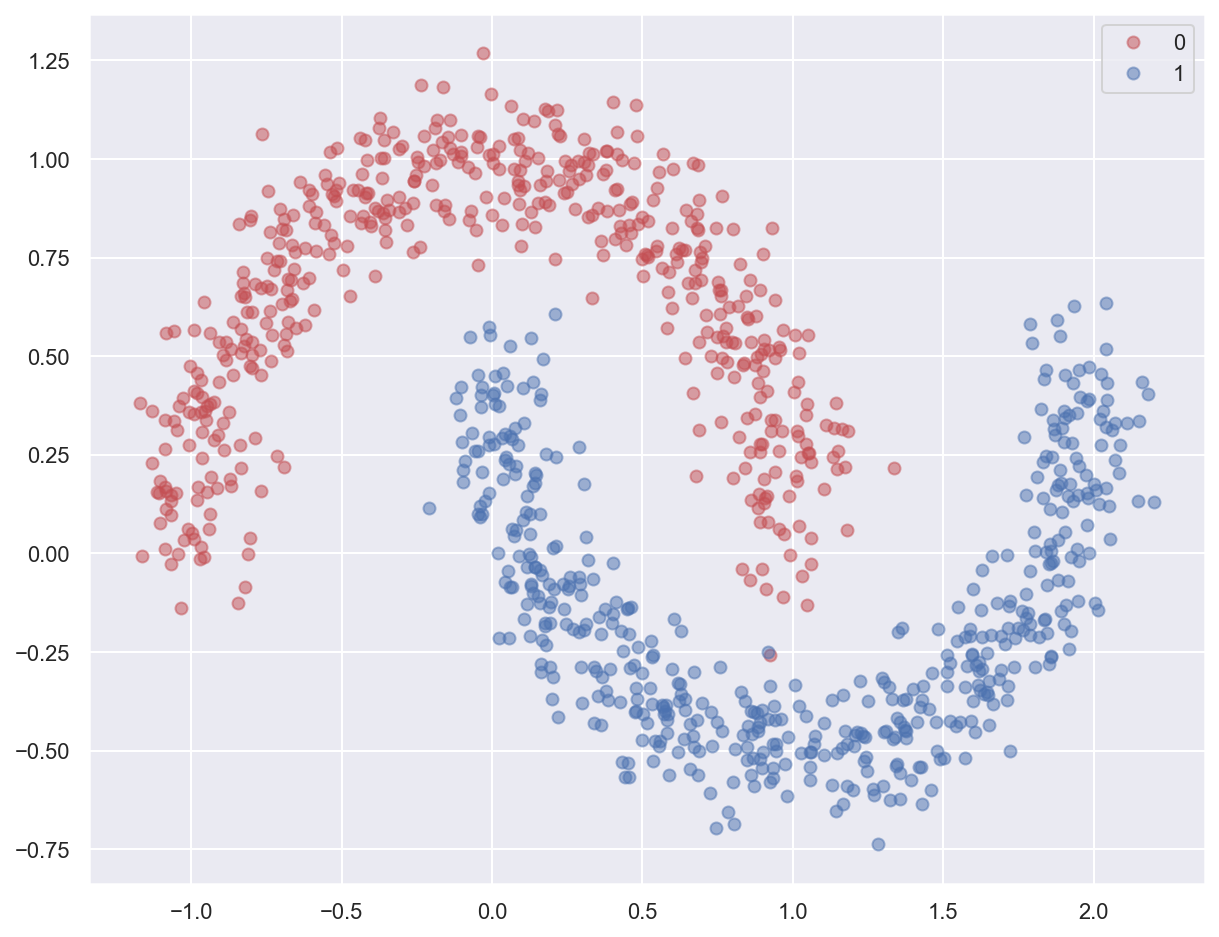

In [5]:
# Generate moon-shaped, non-linearly separable data
x_train, y_train = make_moons(n_samples=1000, noise=0.10, random_state=0)

print(f'x_train: {x_train.shape}. y_train: {y_train.shape}')
plot_planar_data(x_train, y_train)

In [6]:
# Create a neural network with one hidden layer
model = Sequential()
model.add(Dense(3, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='sigmoid'))

# Describe the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 9         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


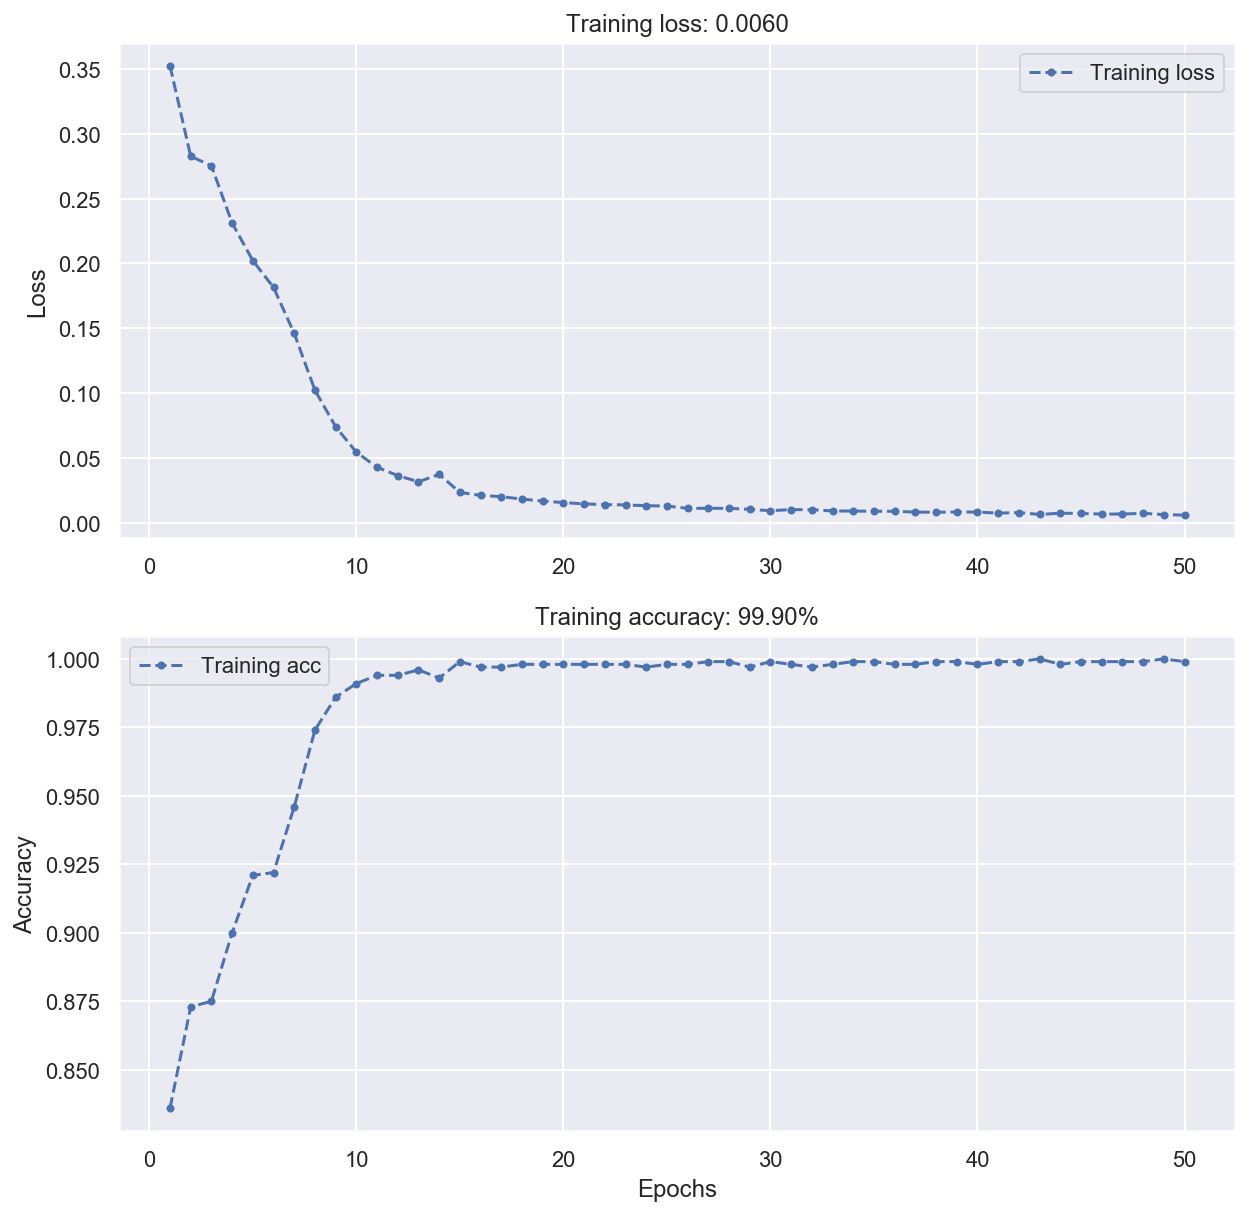

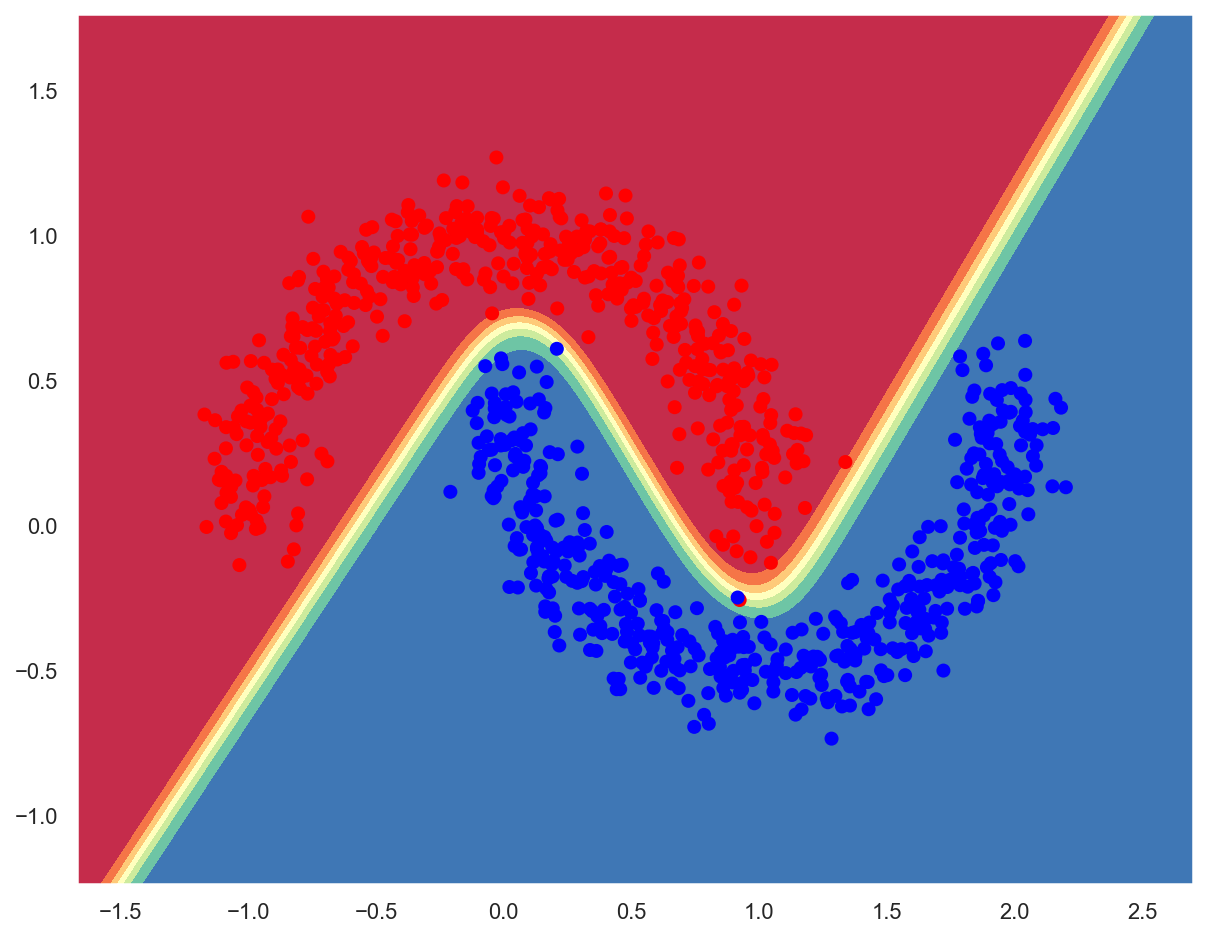

In [7]:
# Compile the model
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])

# Train the model on the data
history = model.fit(x_train, y_train, verbose=0, epochs=50)

# Show training results
plot_loss_acc(history)
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

x_train: (1000, 2). y_train: (1000,)


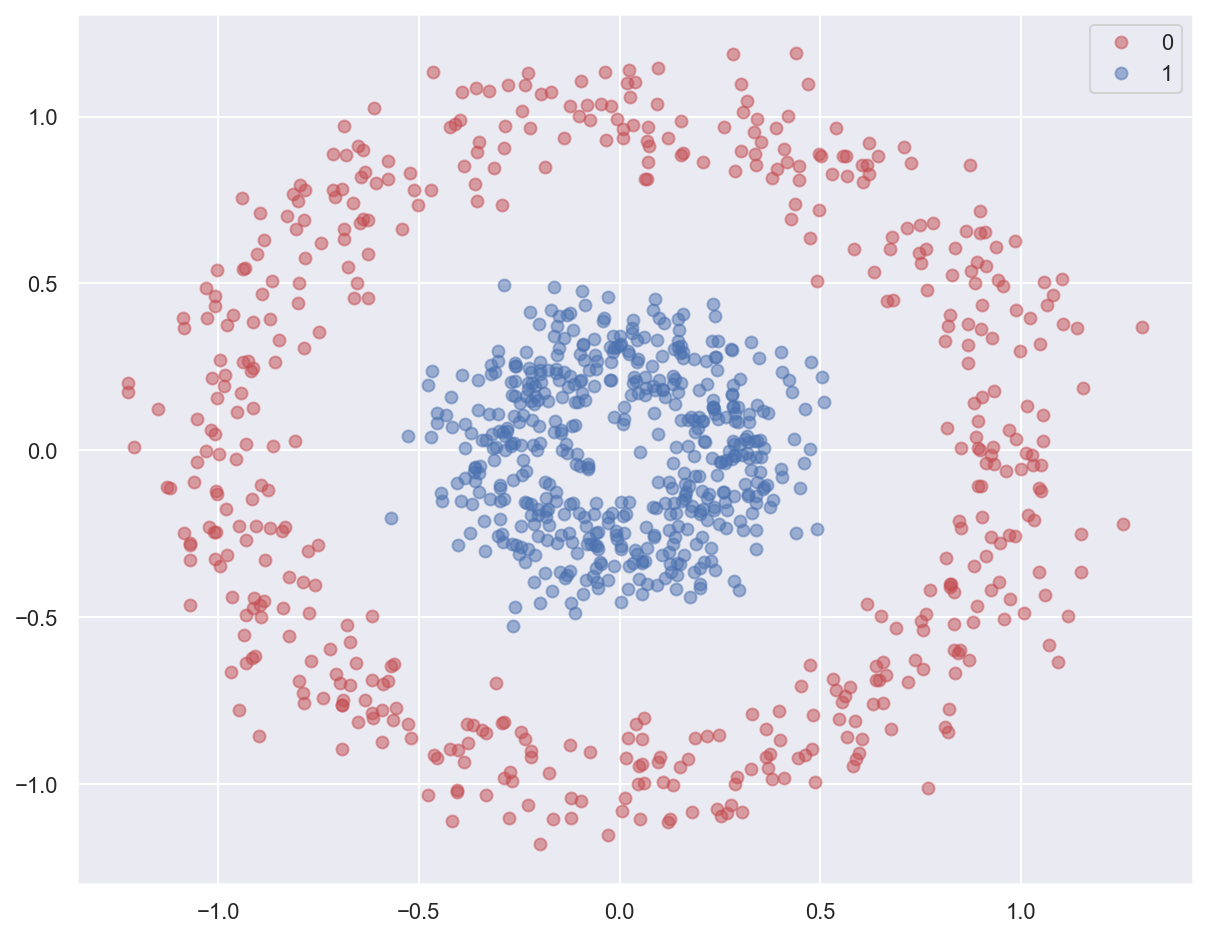

In [8]:
# Generate circle-shaped data
x_train, y_train = make_circles(n_samples=1000, noise=0.10, factor=0.3, random_state=0)

print(f'x_train: {x_train.shape}. y_train: {y_train.shape}')
plot_planar_data(x_train, y_train)

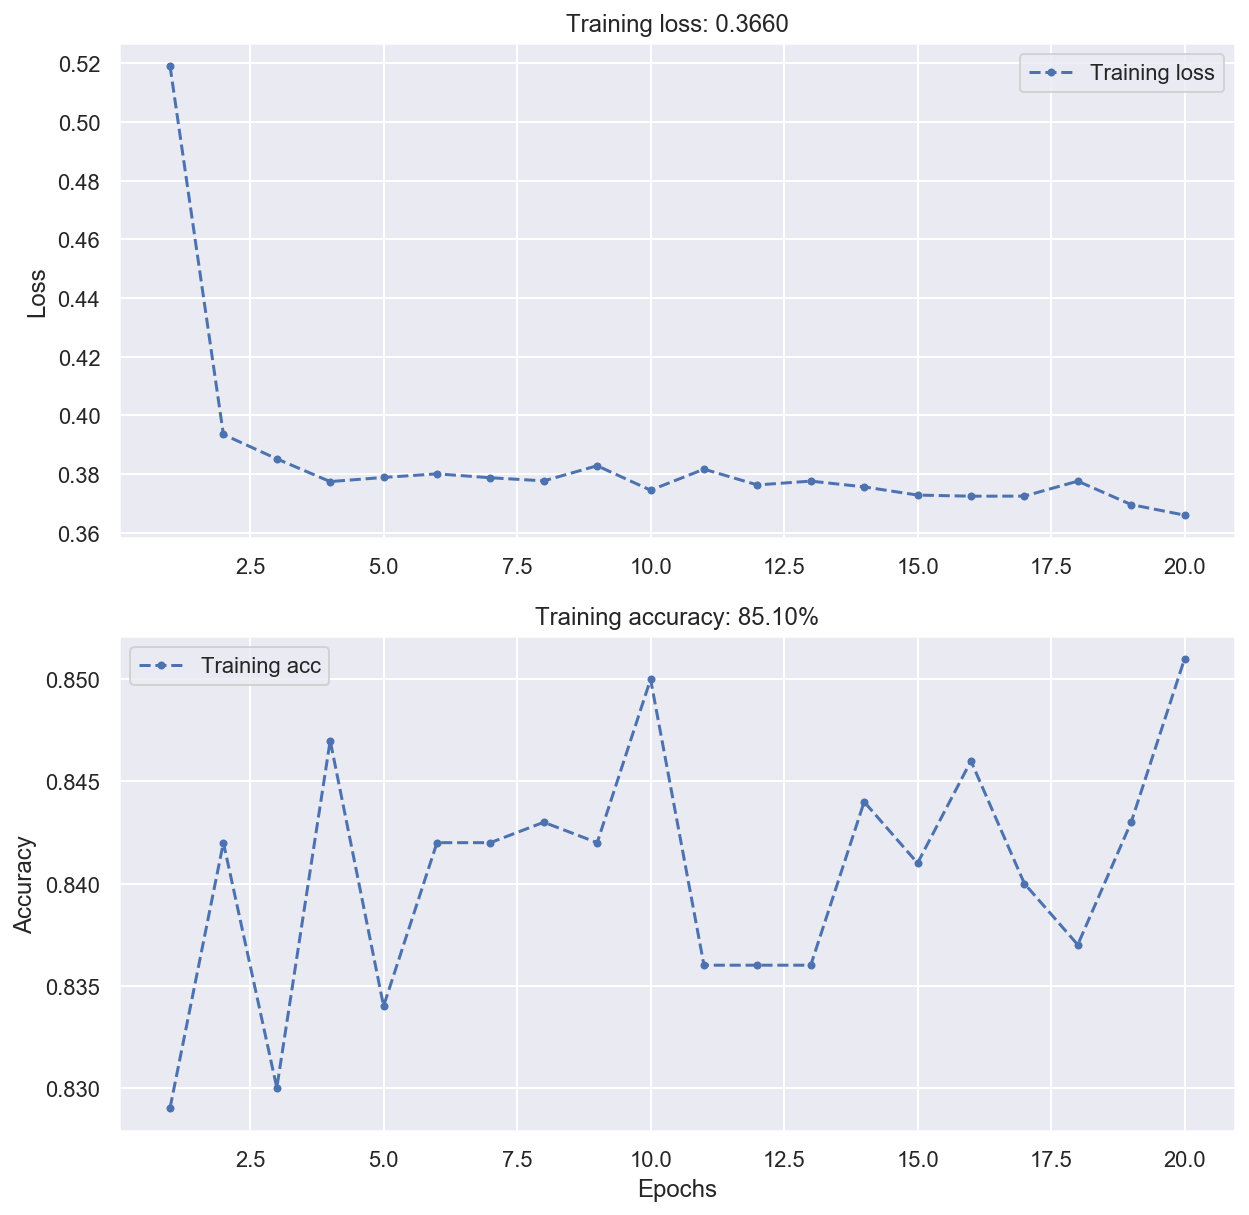

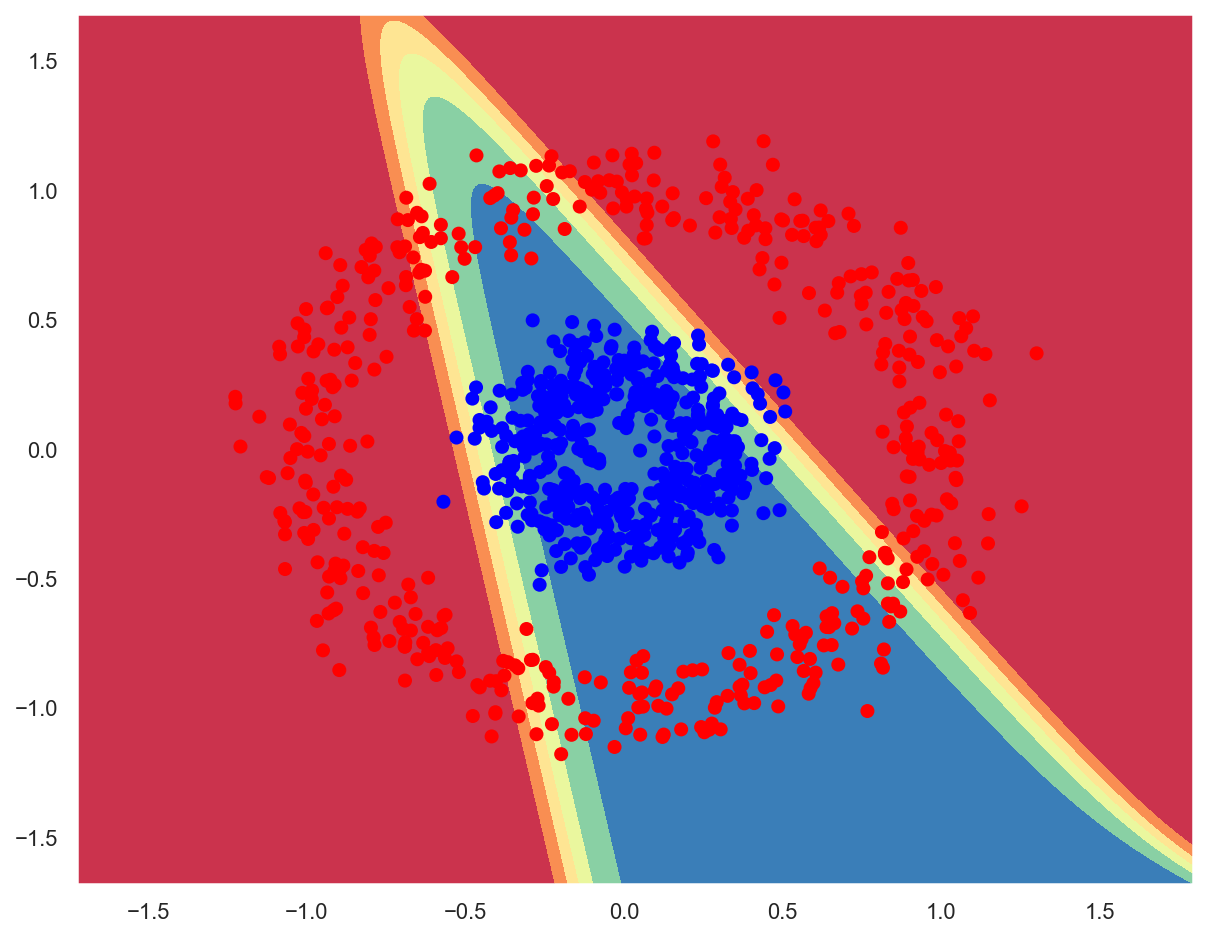

In [9]:
# Train the previous model on the data
history = model.fit(x_train, y_train, verbose=0, epochs=20)

# Show training results
plot_loss_acc(history)
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

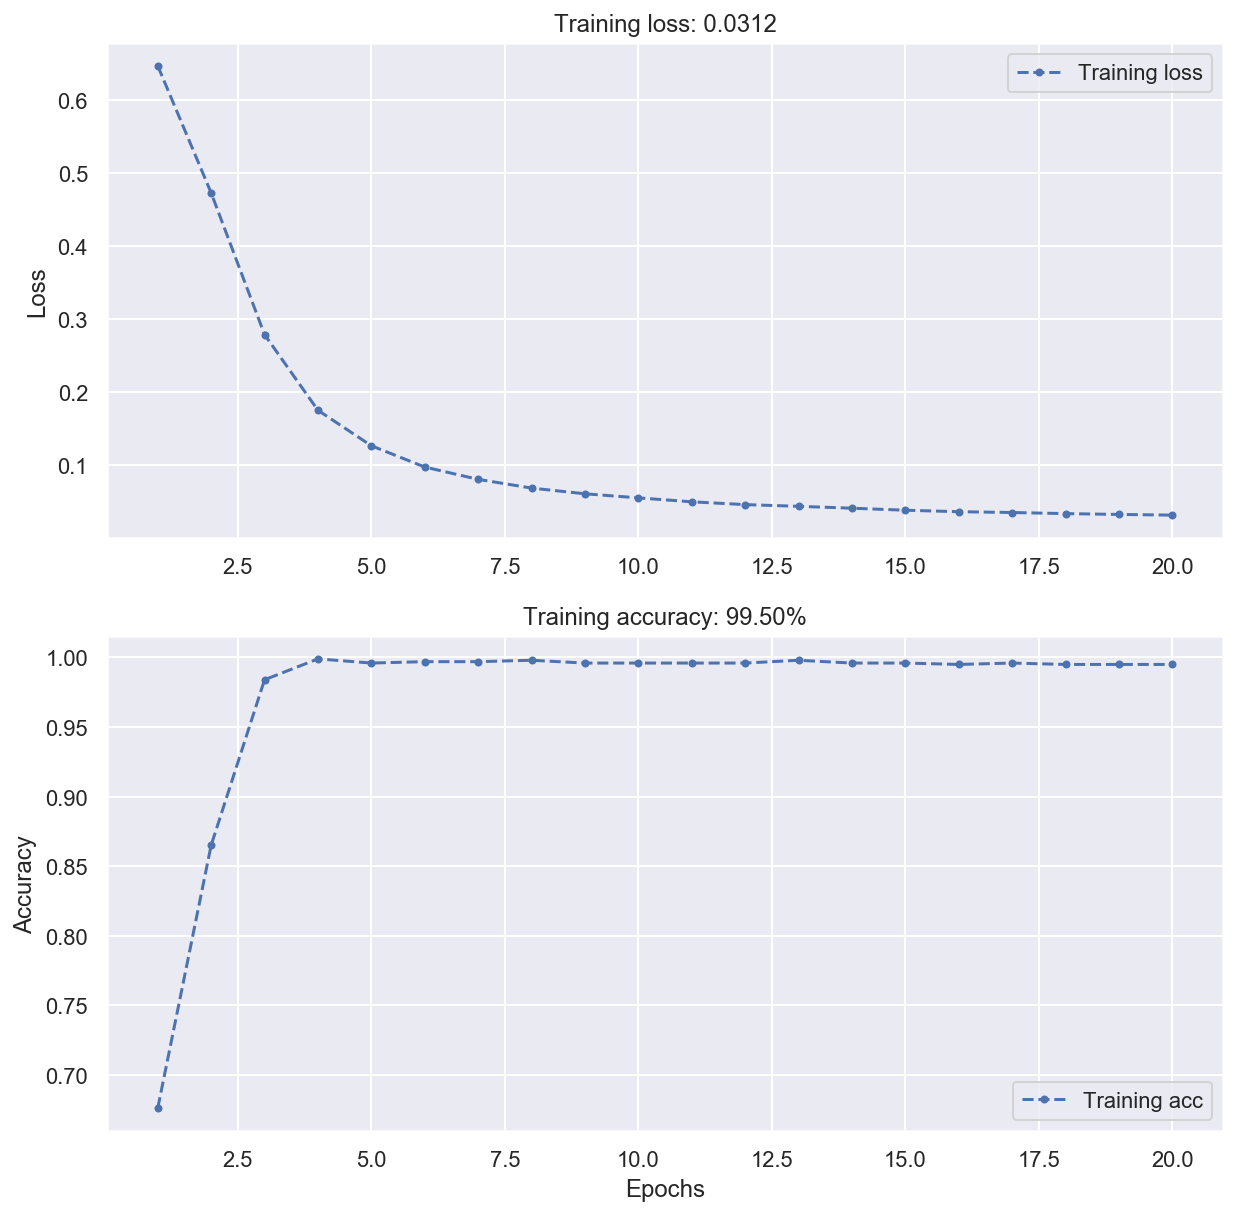

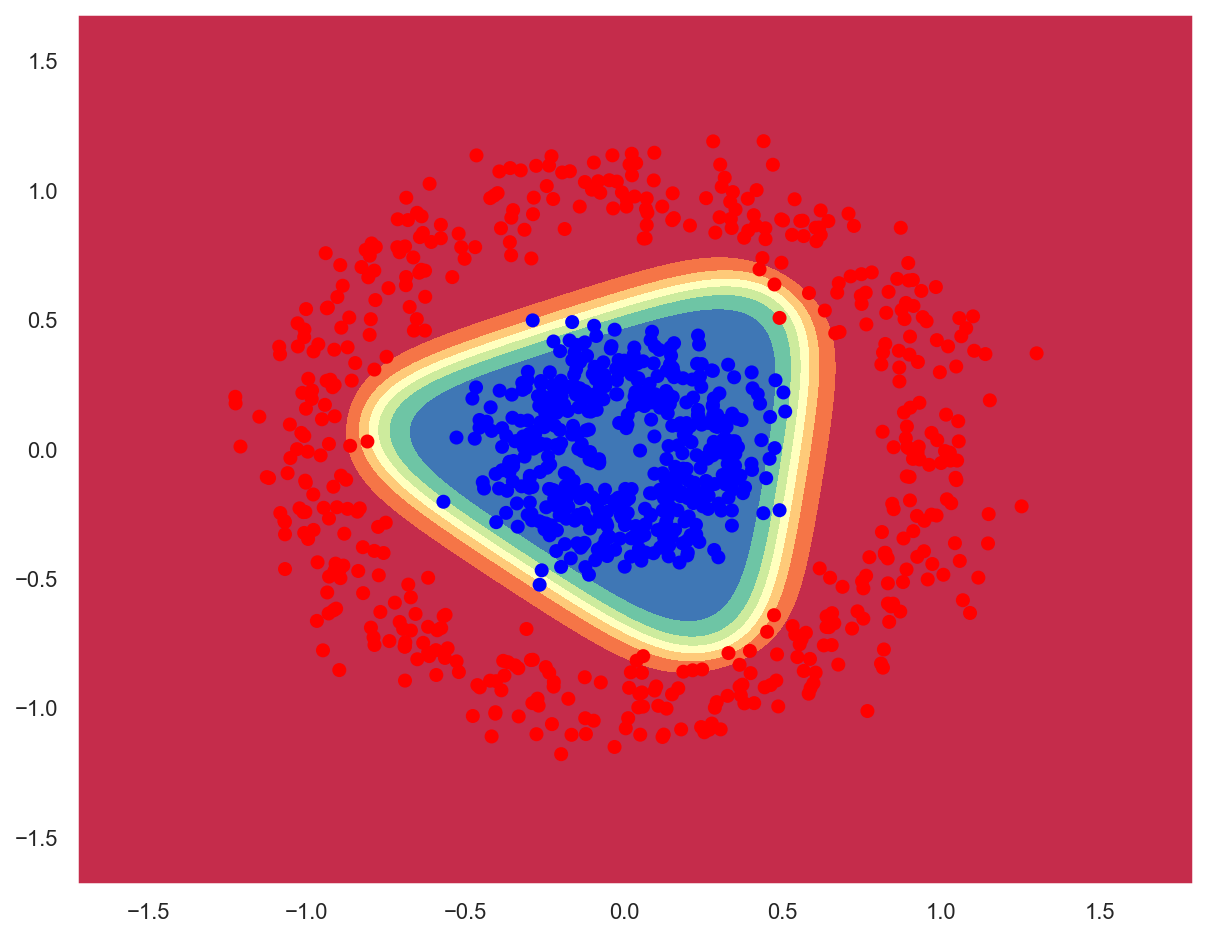

In [10]:
# Add a neuron on the hidden layer for better results
model = Sequential()
model.add(Dense(4, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])
# Train the model on the data
history = model.fit(x_train, y_train, verbose=0, epochs=20)

# Show training results
plot_loss_acc(history)
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

x_train: (1500, 2). y_orig: (1500,)


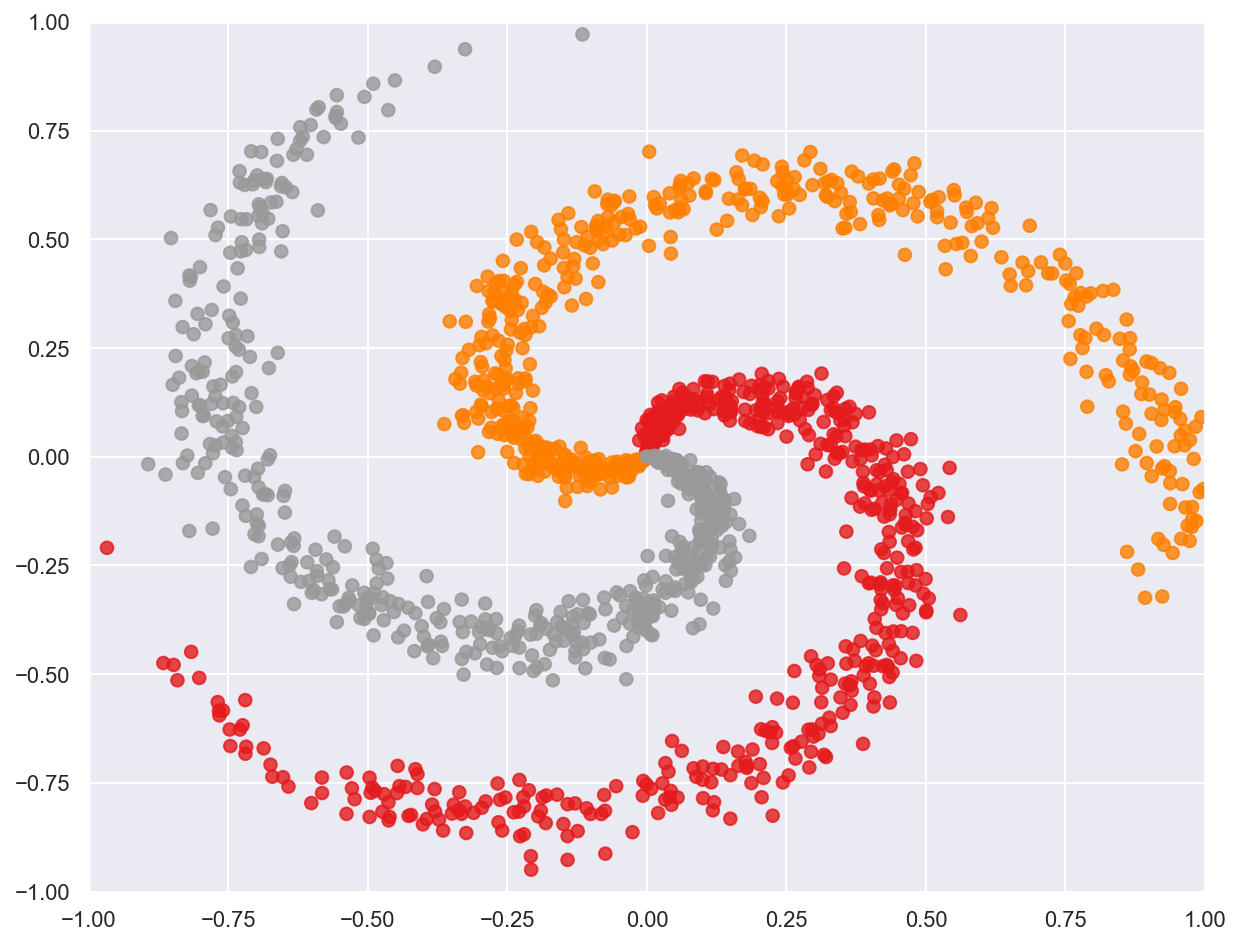

In [11]:
# Generate and plot spiral-shaped data with 3 classes
x_train, y_orig = make_multiclass(K=3)

print(f'x_train: {x_train.shape}. y_orig: {y_orig.shape}')
plot_multiclass(x_train, y_orig)

In [12]:
# Labels are integer scalars: 0, 1 or 2
df_y_orig = pd.DataFrame(y_orig)
df_y_orig.columns = {'label'}
# df_y_orig['label'].value_counts()
df_y_orig.sample(n=10)

label
1338    2.0
526     1.0
1192    2.0
809     1.0
1051    2.0
926     1.0
56      0.0
487     0.0
468     0.0
765     1.0

In [13]:
# to_categorical() converts a vector of discrete values into a binary matrix
# This is called one-hot encoding
y_train = to_categorical(y_orig)

print(f'y_train: {y_train.shape}')

# Labels are now binary vectors
df_y_train = pd.DataFrame(y_train)
df_y_train.sample(n=10)

y_train: (1500, 3)


0    1    2
1483  0.0  0.0  1.0
720   0.0  1.0  0.0
1356  0.0  0.0  1.0
839   0.0  1.0  0.0
1068  0.0  0.0  1.0
361   1.0  0.0  0.0
637   0.0  1.0  0.0
283   1.0  0.0  0.0
311   1.0  0.0  0.0
262   1.0  0.0  0.0

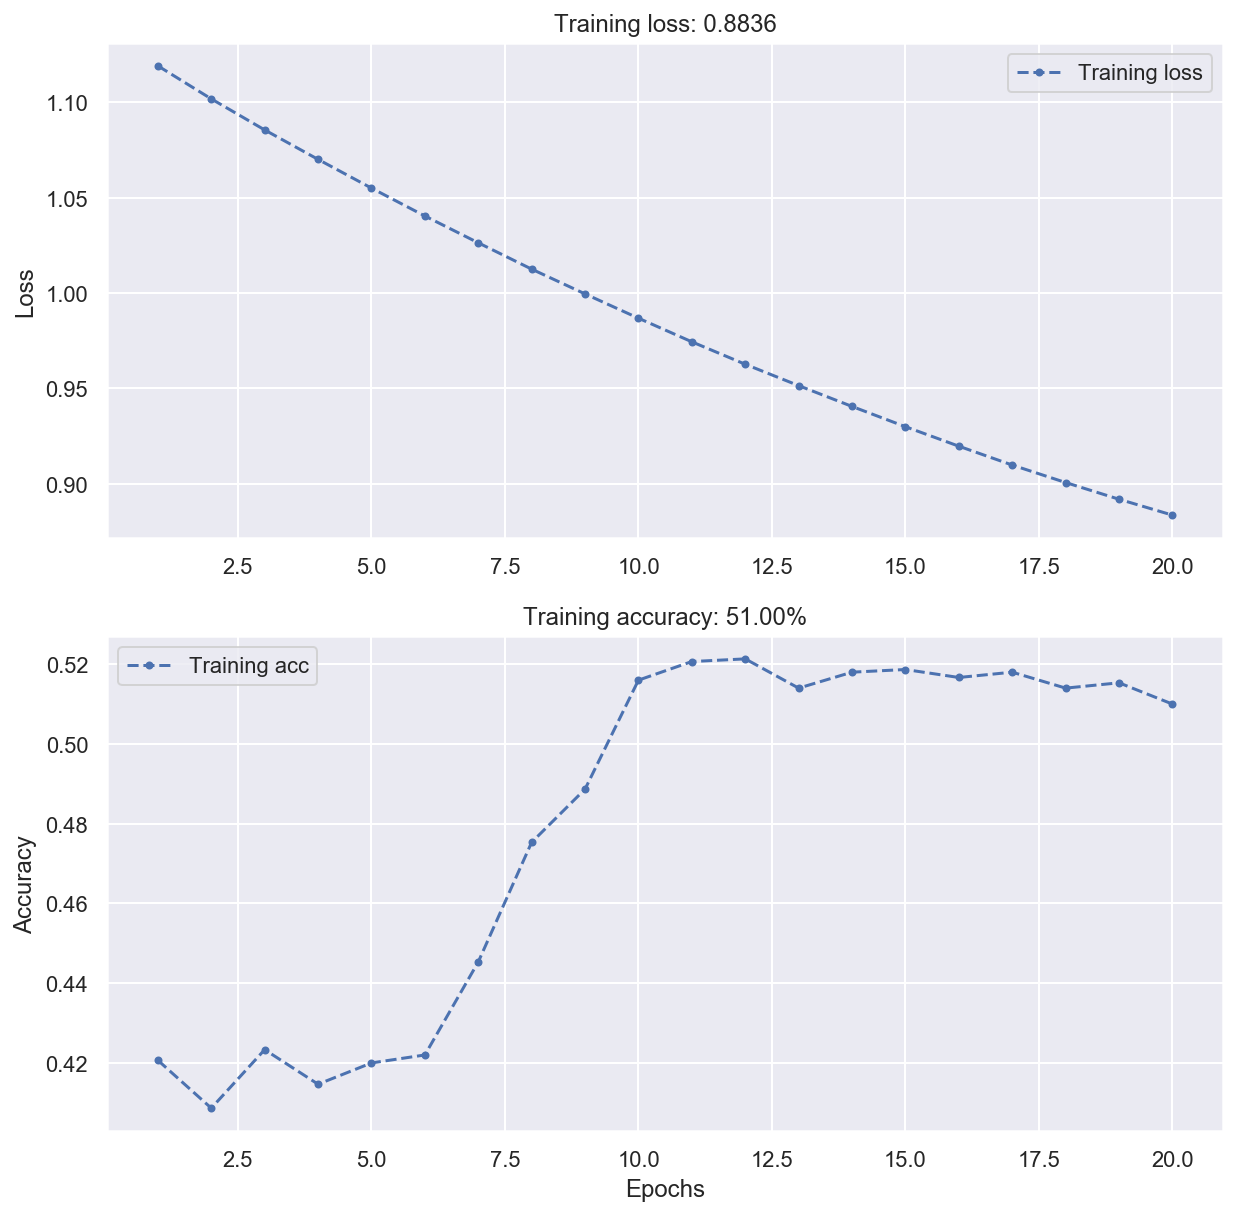

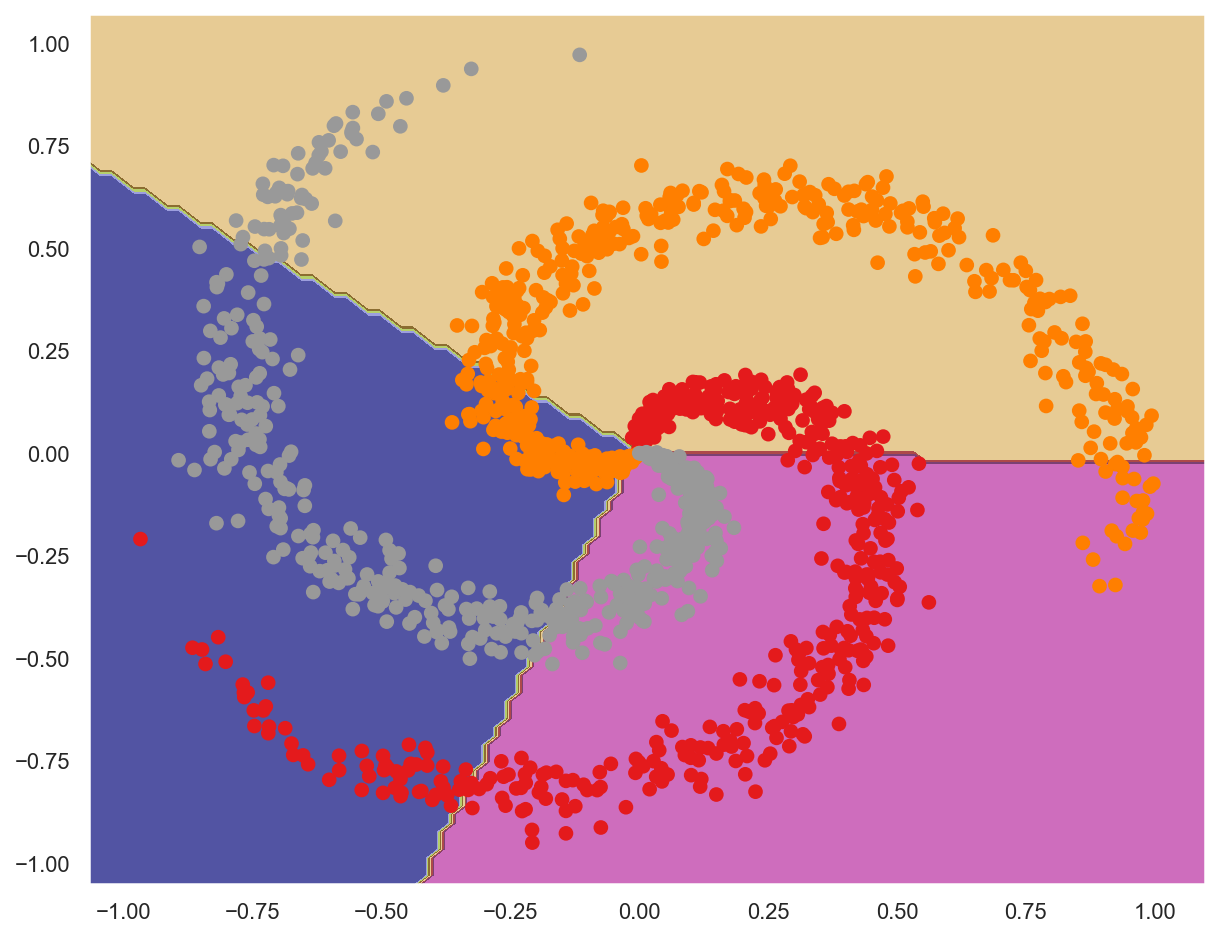

In [14]:
# Create a (2, 3) model with a softmax activation function on the output layer
model = Sequential()
model.add(Dense(3, activation='softmax', input_shape=(2,)))

model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, verbose=0, epochs=20)

plot_loss_acc(history)
plot_multiclass_decision_boundary(model, x_train, y_orig)

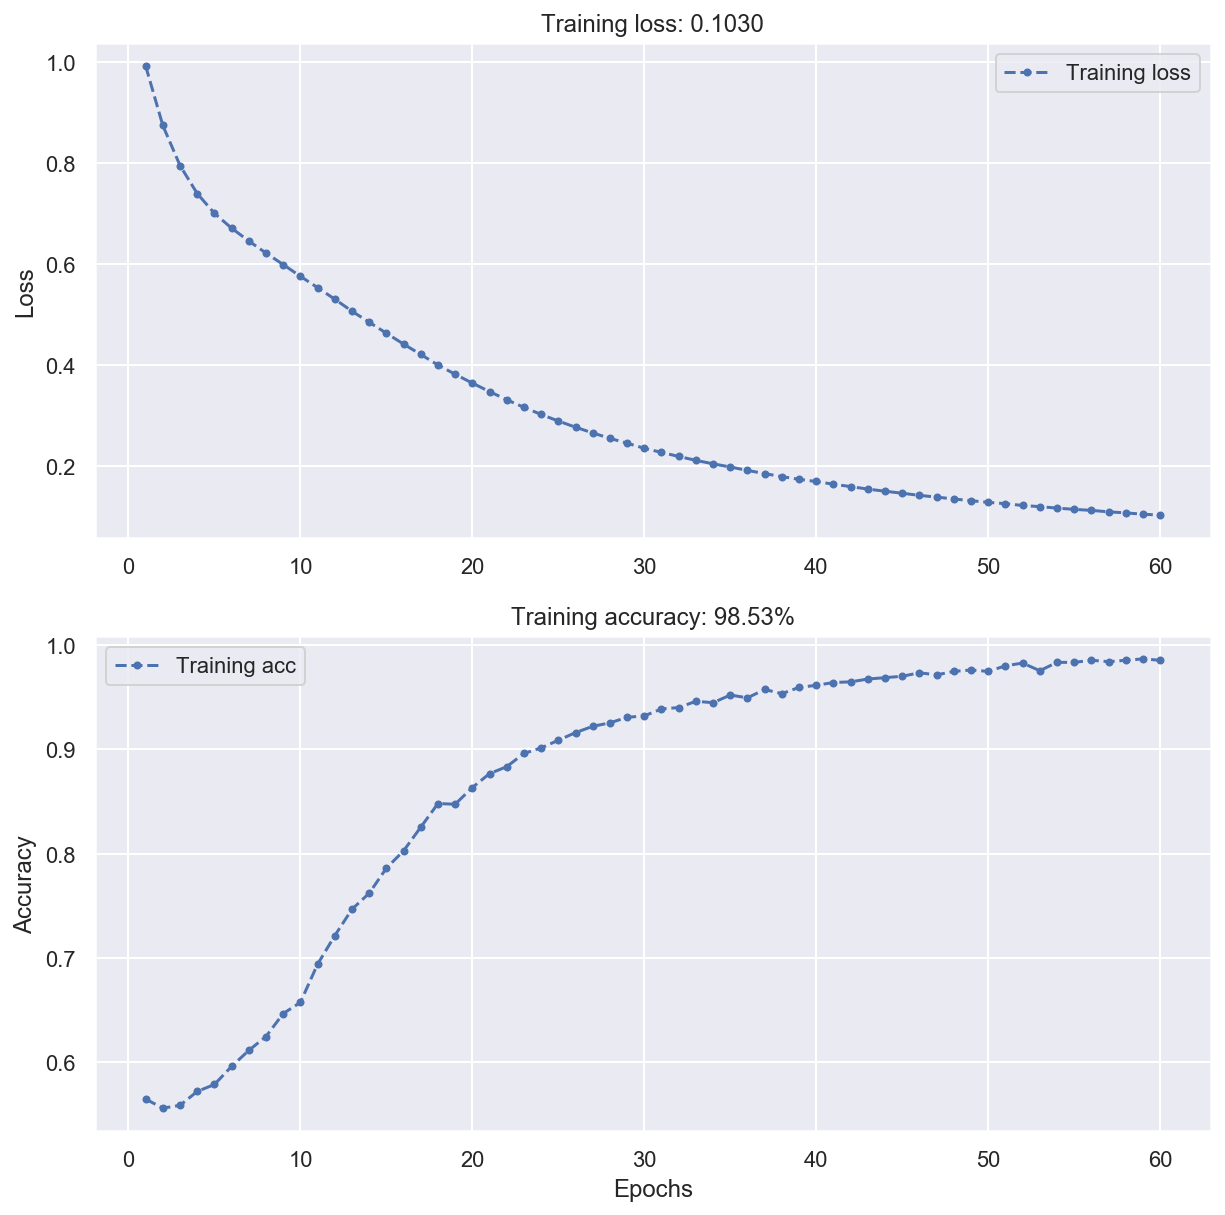

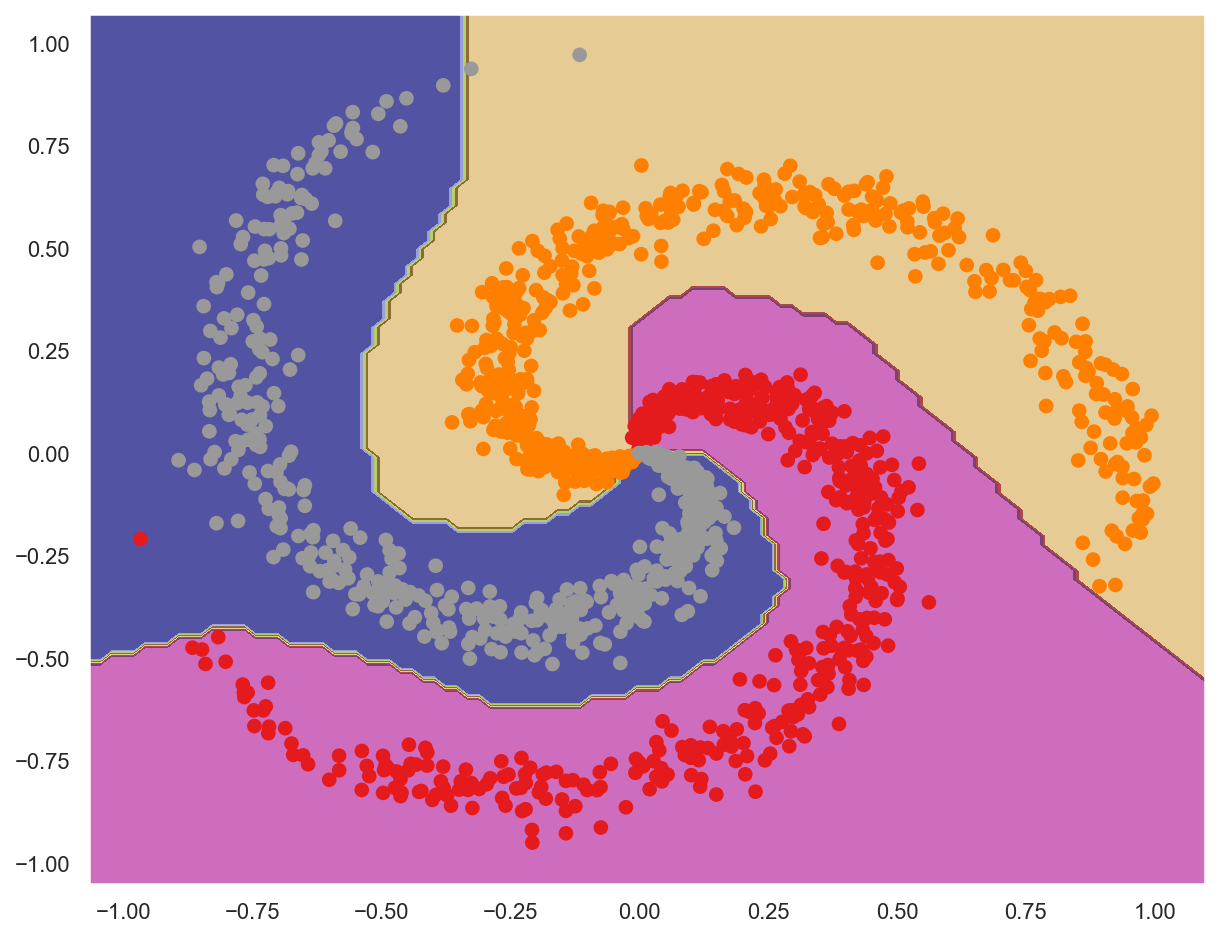

In [15]:
# Change model architecture to a (2, 100, 3) network
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(2,)))
model.add(Dense(3, activation='softmax'))

model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, verbose=0, epochs=60)
plot_loss_acc(history)
plot_multiclass_decision_boundary(model, x_train, y_orig)

## MNIST Digits

In [16]:
# Load the Keras MNIST digits dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(f'Training images: {train_images.shape}. Training labels: {train_labels.shape}')

Training images: (60000, 28, 28). Training labels: (60000,)


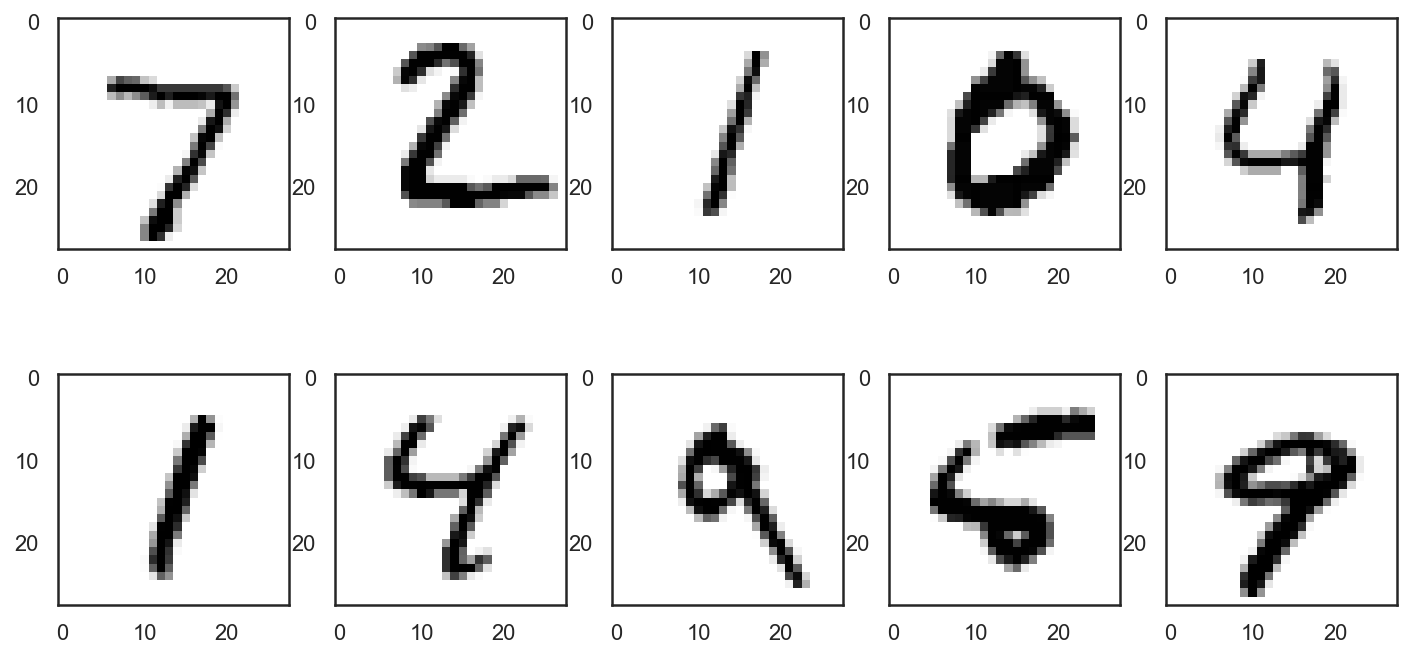

In [17]:
# Plot the first 10 digits

# Temporary hide Seaborn grid lines
with sns.axes_style('white'):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        digit = test_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(digit, cmap=plt.cm.binary)

In [18]:
# Labels are integer scalars between 0 and 9
df_train_labels = pd.DataFrame(train_labels)
df_train_labels.columns = {'digit'}
# df_train_labels['digit'].value_counts()
df_train_labels.sample(n=15)

digit
5959       7
18287      3
21607      3
17301      3
38757      4
36845      8
39618      3
45340      3
40290      5
5110       2
11552      2
32734      6
55153      8
13239      3
37493      8

In [19]:
# Reshape images data into a (number of samples, 28x28) matrix
x_train = train_images.reshape((60000, 28 * 28))
x_test = test_images.reshape((10000, 28 * 28))

# Change pixel values from (0, 255) to (0, 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encoding of expected results
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print(f'y_train: {y_train.shape}')

# Show a sample of encoded input
df_y_train = pd.DataFrame(y_train)
df_y_train.sample(n=10)

y_train: (60000, 10)


0    1    2    3    4    5    6    7    8    9
59714  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
13838  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
5632   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
58852  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
35809  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
11783  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
35454  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11074  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
17539  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7719   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [20]:
# Create a (784, 15, 10) model
model = Sequential()

# Use ReLU for hidden layer
model.add(Dense(15, activation='relu', input_shape=(28 * 28,)))

# Use softmax for output layer
model.add(Dense(10, activation='softmax'))

# Describe the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 15)                11775     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.6329 - accuracy: 0.8256
Epoch 2/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3085 - accuracy: 0.9124s - loss: 0.3133 - accuracy
Epoch 3/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2686 - accuracy: 0.9234
Epoch 4/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2469 - accuracy: 0.9287
Epoch 5/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2315 - accuracy: 0.9341
Epoch 6/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2199 - accuracy: 0.9369s - loss: 0.2146 - accuracy - ETA: 0s - loss: 0.2114 
Epoch 7/10
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2087 - accuracy: 0.9403
Epoch 8/10
60000/60000 [==============================] - 1s 16us/sample - loss: 0.2001 - accuracy: 0.9431s - loss: 0.1969 - ac
Epoch 9/10
60000/600

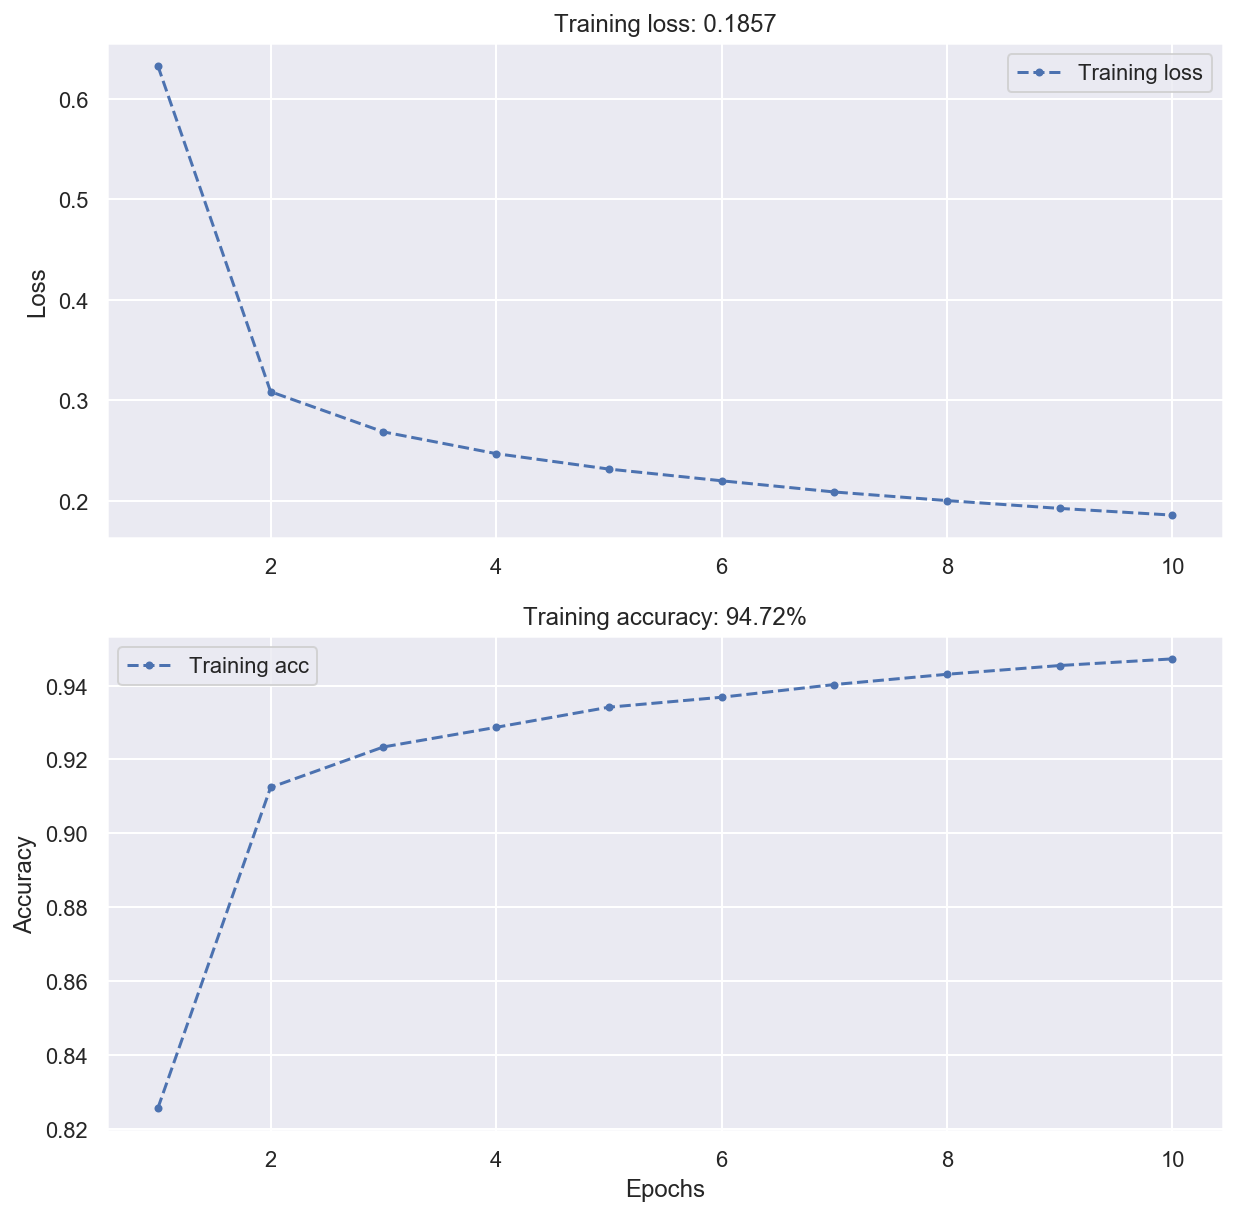

In [21]:
# Train the model and show results
model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128)
plot_loss_acc(history)

In [22]:
# Evaluate the model on test data
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f'Test accuracy: {test_acc * 100:.2f}%')

Test accuracy: 94.26%


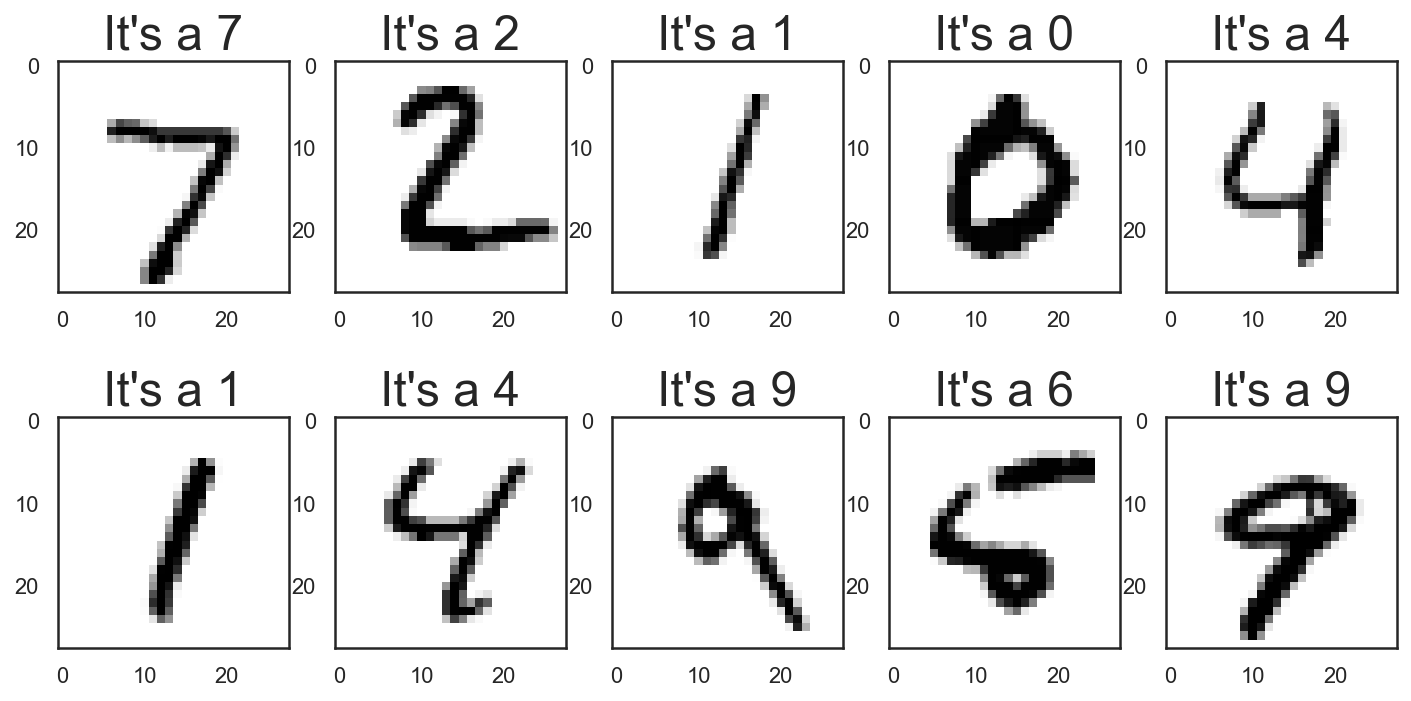

In [23]:
# Plot the first 10 digits with associated predictions

# Temporary hide Seaborn grid lines
with sns.axes_style('white'):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        digit = test_images[i]
        prediction = np.argmax(model.predict(
            digit.reshape((1, 28 * 28))))
        fig = plt.subplot(2, 5, i + 1)
        plt.title('It\'s a {:d}'.format(prediction), fontsize=24)
        plt.imshow(digit, cmap=plt.cm.binary)

In [24]:
# Saving model for future use
model_json = model.to_json()

with open("model.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("model.h5")

## Neural Networks Tuning

### Observing underfitting and overfitting

Inspired by [this article](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/).

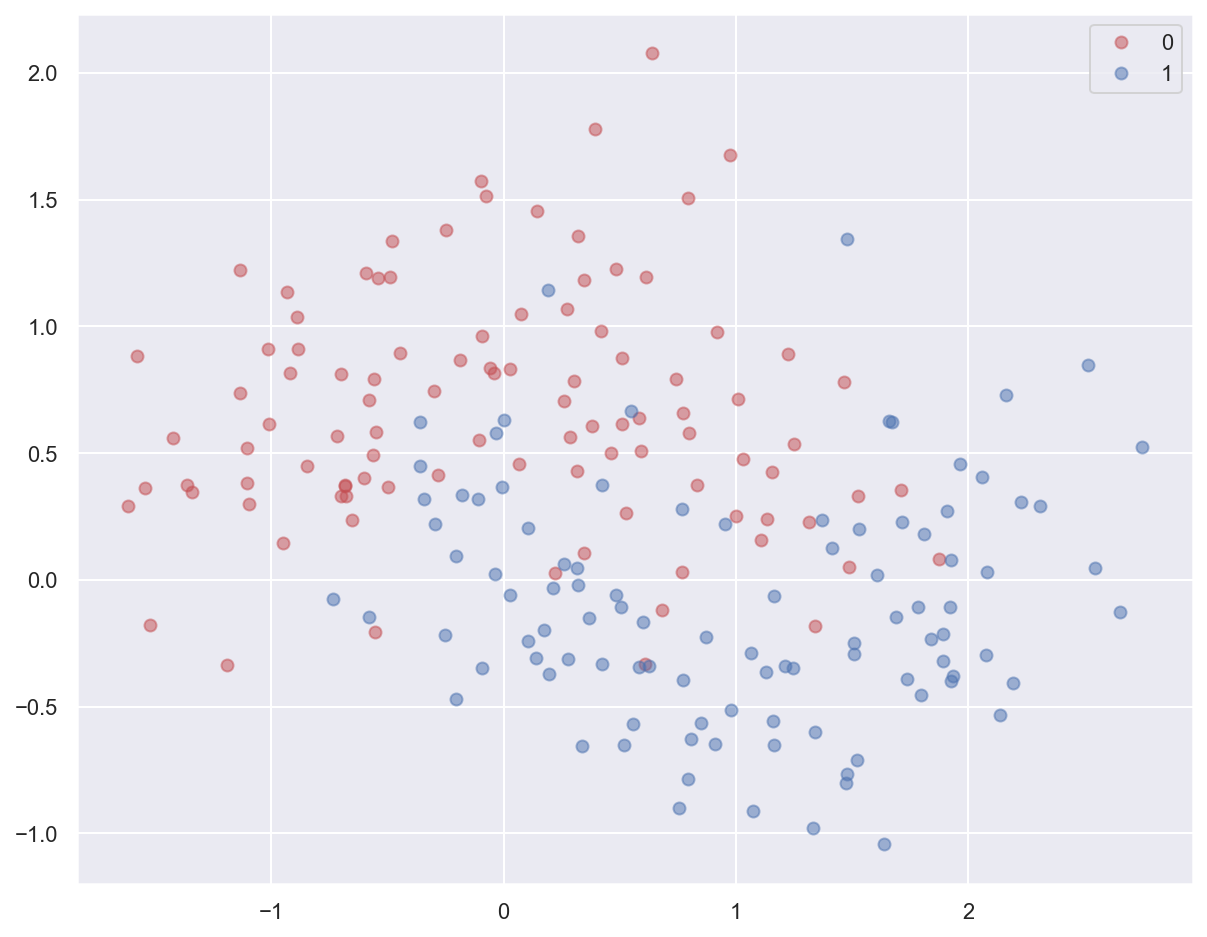

In [26]:
# Generate moon-shaped data with some noise
x_train, y_train = make_moons(200, noise=0.40)

plot_planar_data(x_train, y_train)

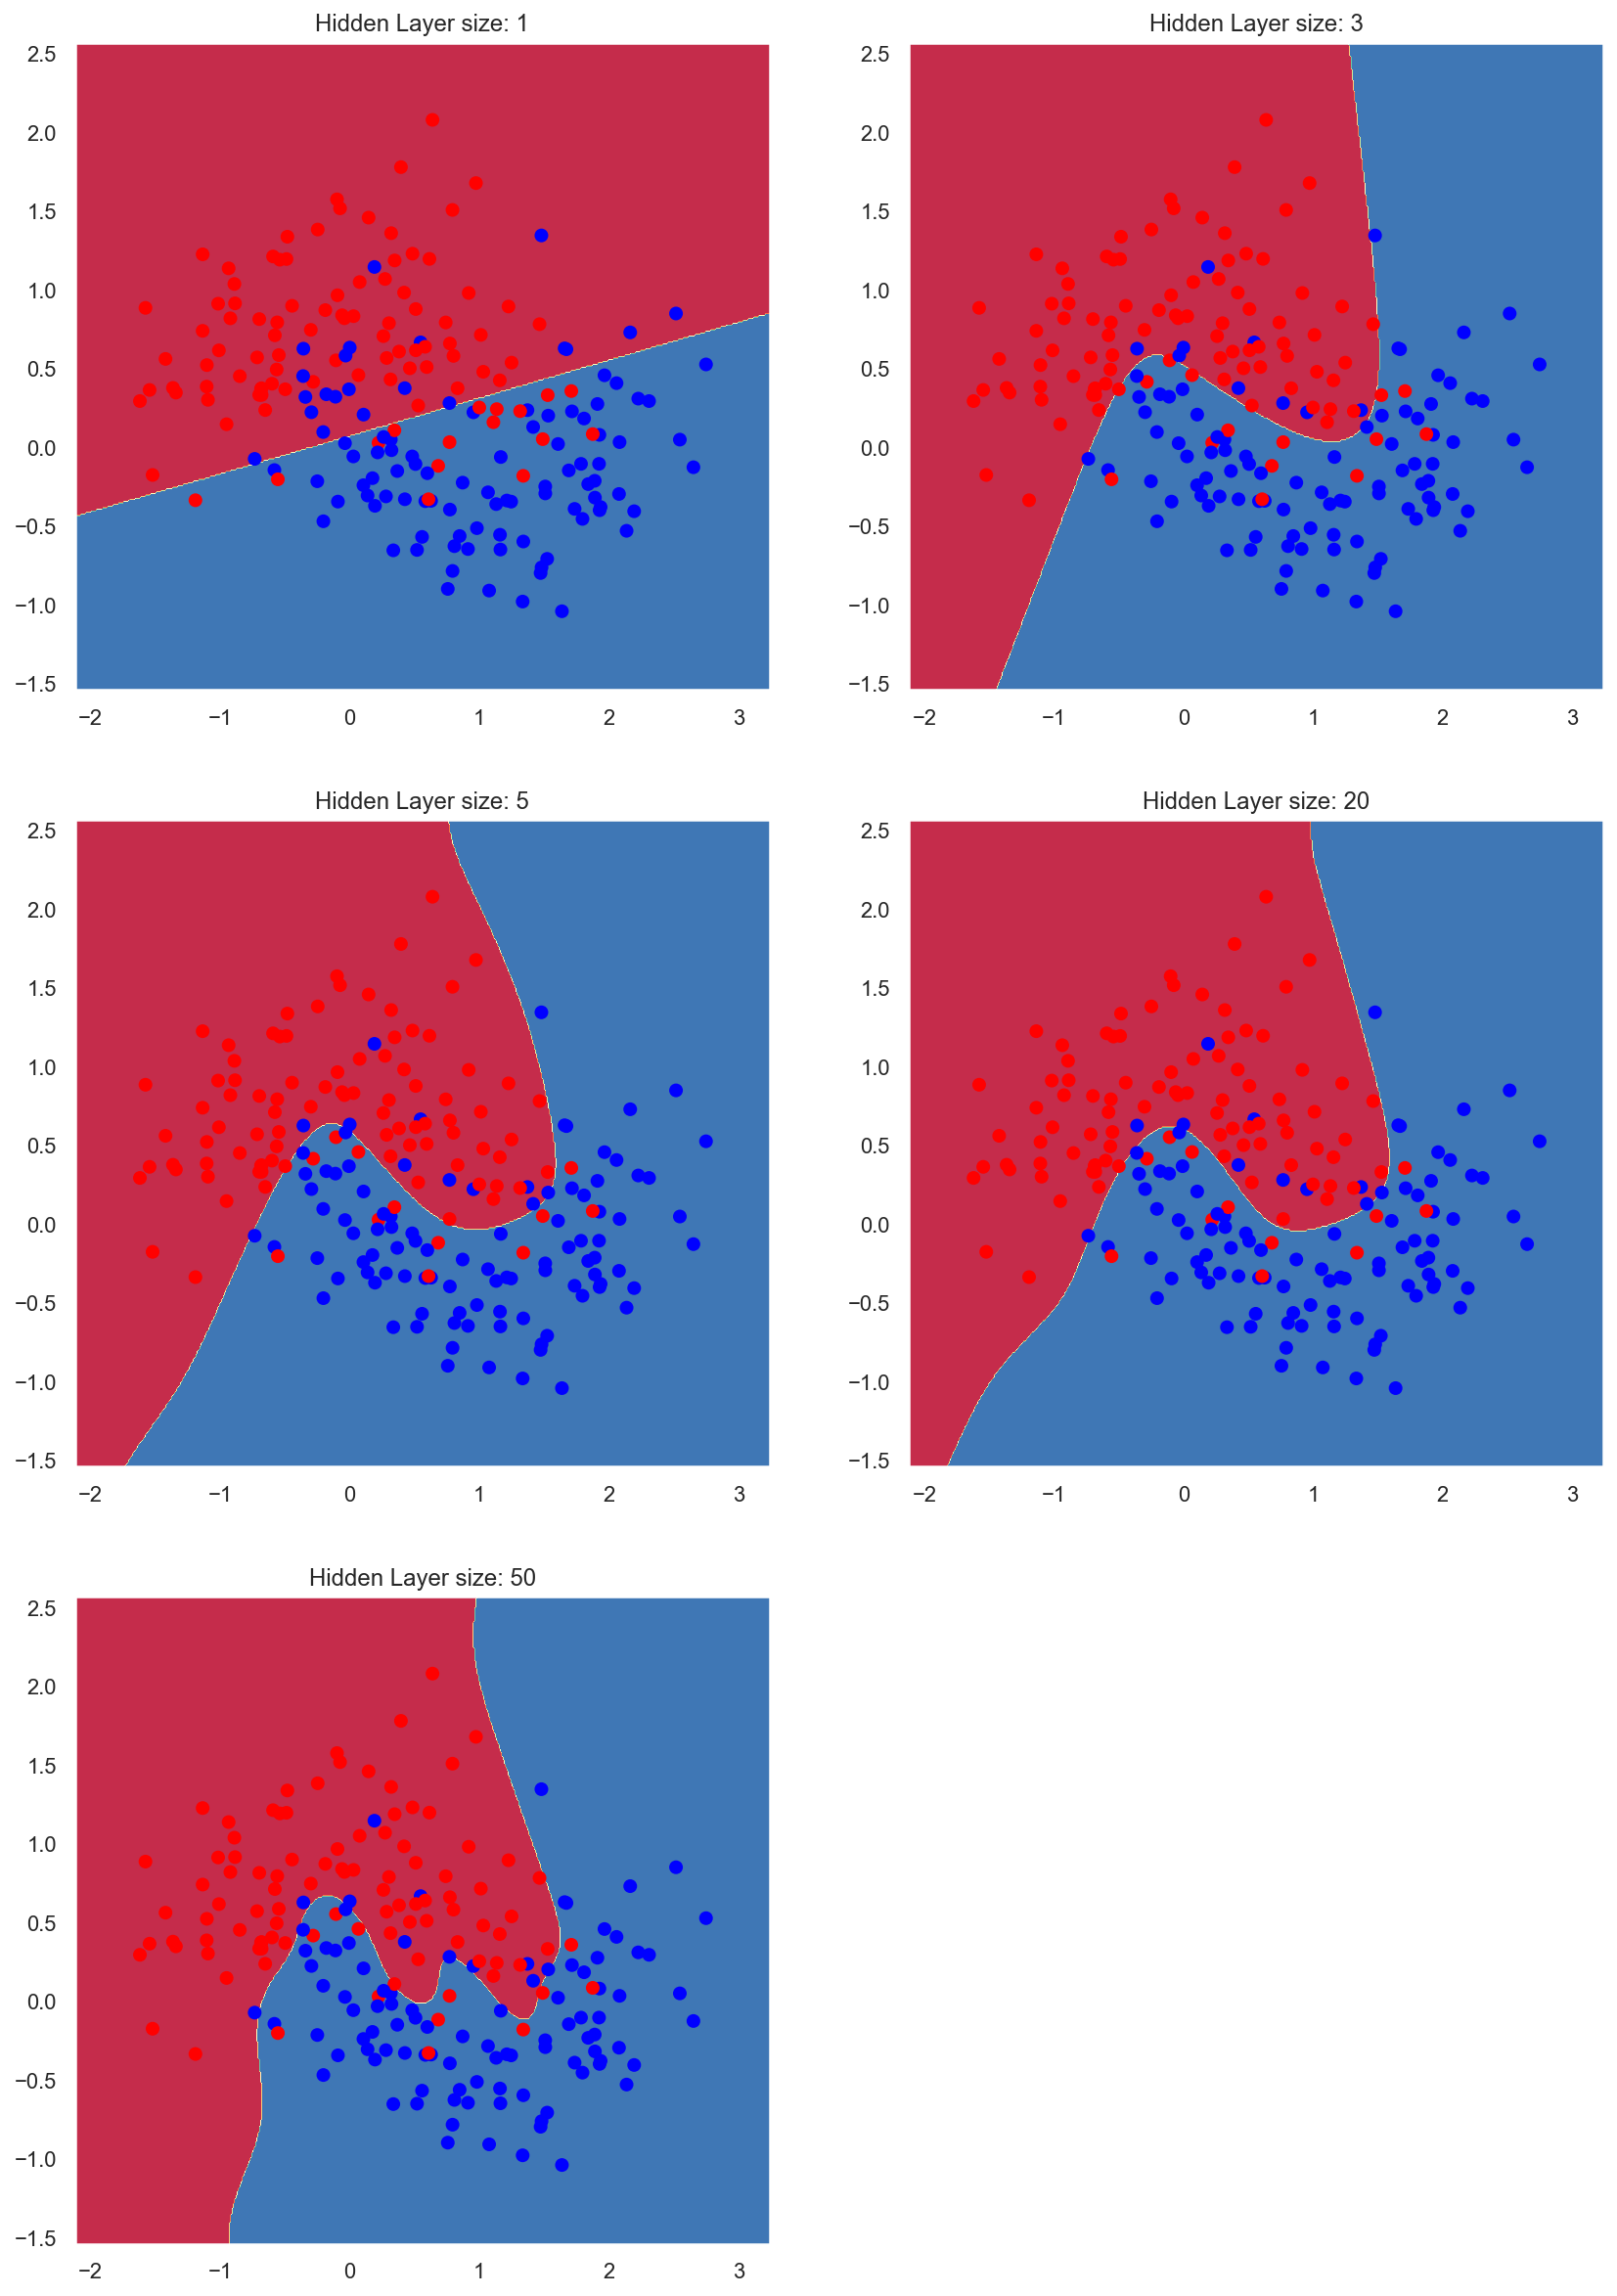

In [27]:
# Varying the hidden layer size to observe underfitting and overfitting

plt.figure(figsize=(14, 28))
hidden_layer_dimensions = [1, 3, 5, 20, 50]
for i, hidden_layer_size in enumerate(hidden_layer_dimensions):
    fig = plt.subplot(4, 2, i+1)
    plt.title('Hidden Layer size: {:d}'.format(hidden_layer_size))
    
    model = Sequential()
    model.add(Dense(hidden_layer_size, activation='tanh', input_shape=(2,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])
    # Batch size = dataset size => batch gradient descent
    history = model.fit(x_train, y_train, verbose=0, epochs=5000, batch_size=x_train.shape[0])

    plot_decision_boundary(lambda x: model.predict(x) > 0.5, x_train, y_train, fig)

### Tackling overfitting

#### Regularization

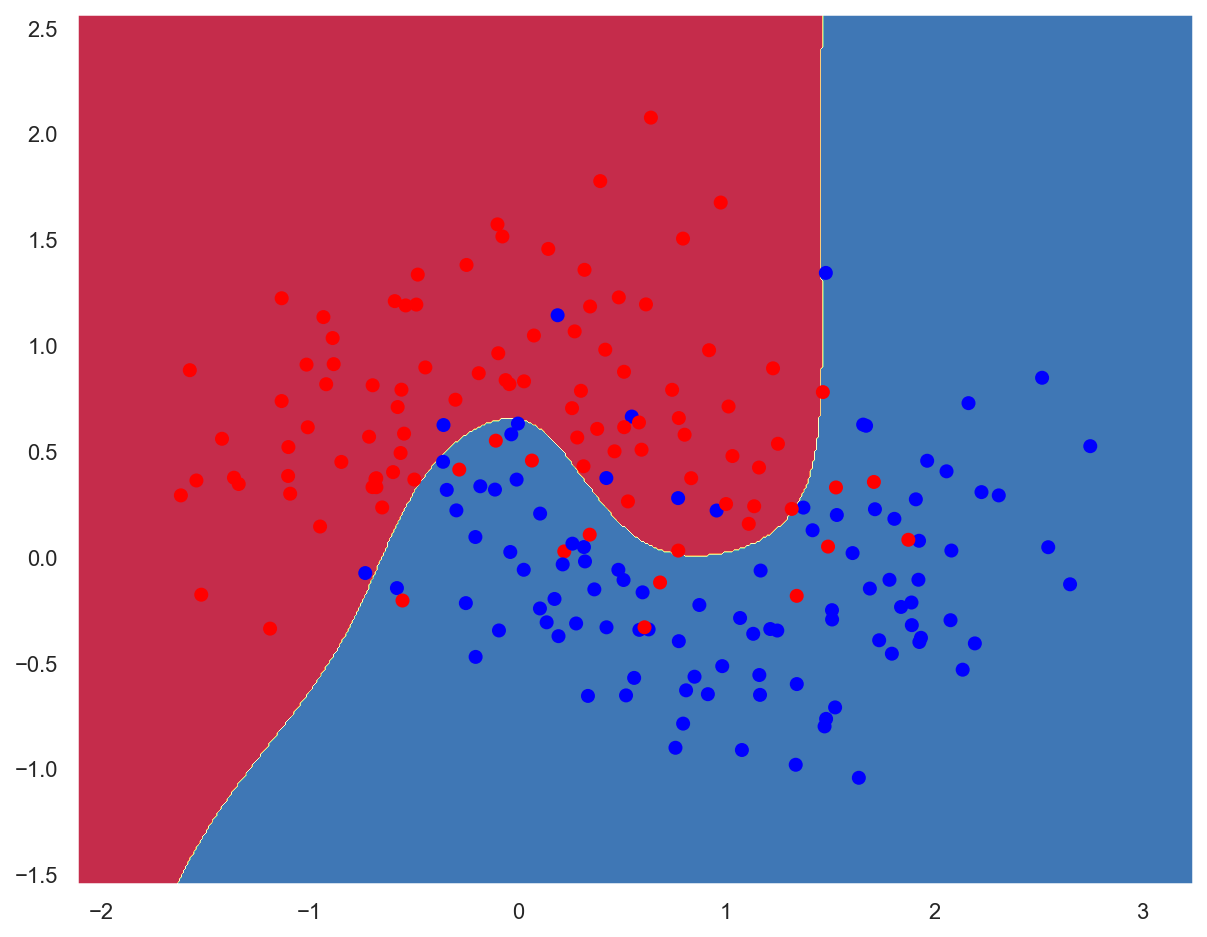

In [30]:
model = Sequential()

# Use L1 regularization on hidden layer
model.add(Dense(50, activation='tanh', input_shape=(2,), 
                kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1, activation='sigmoid'))
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])

# Batch size = dataset size => batch gradient descent
history = model.fit(x_train, y_train, verbose=0, epochs=5000, batch_size=x_train.shape[0])

plot_decision_boundary(lambda x: model.predict(x) > 0.5, x_train, y_train)

#### Dropout

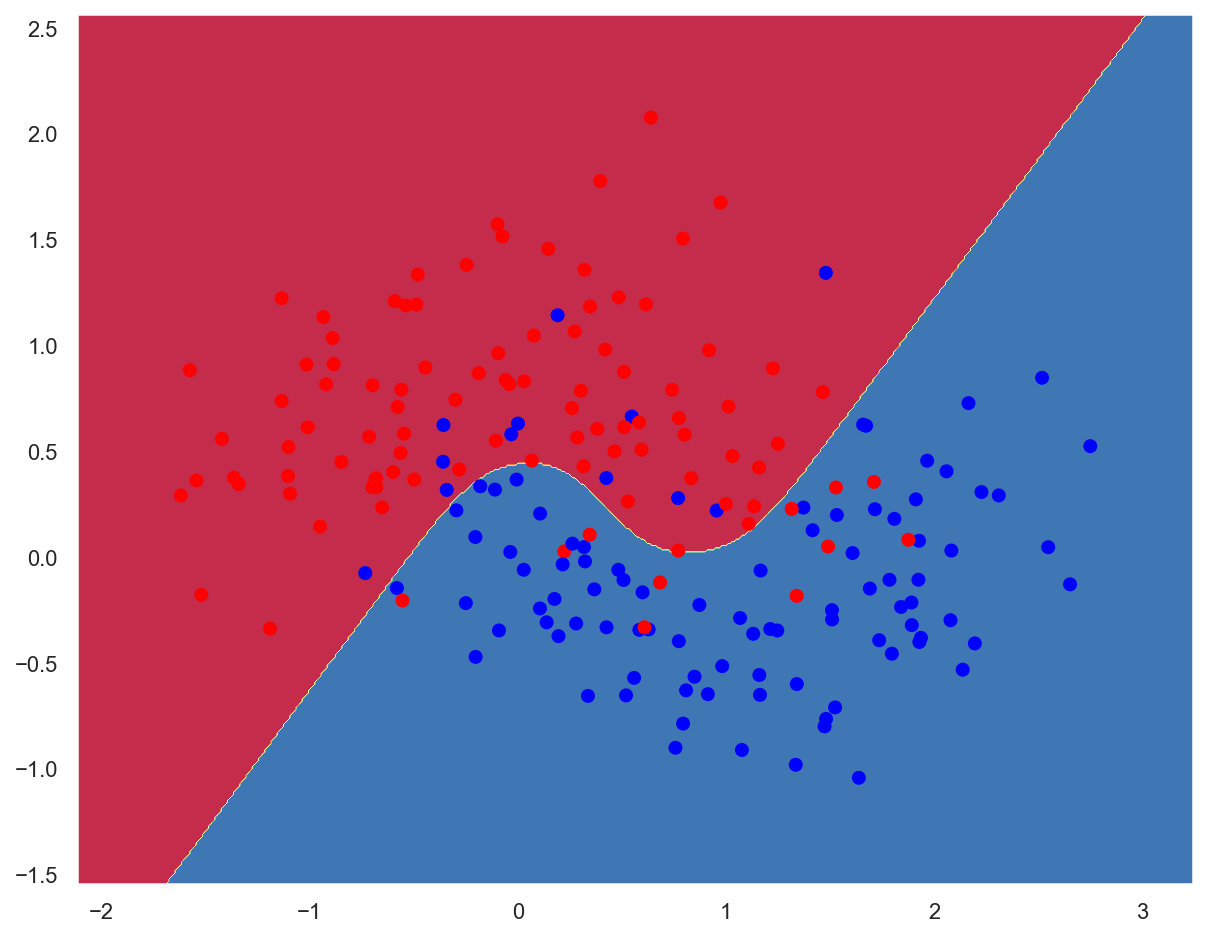

In [31]:
model = Sequential()

# Use 25% dropout on hidden layer
model.add(Dense(50, activation='tanh', input_shape=(2,)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(SGD(lr=1.0), 'binary_crossentropy', metrics=['accuracy'])

# Batch size = dataset size => batch gradient descent
history = model.fit(x_train, y_train, verbose=0, epochs=5000, batch_size=x_train.shape[0])

plot_decision_boundary(lambda x: model.predict(x) > 0.5, x_train, y_train)

## Overfitting on a real-world example

Heavily inspired by a use case in François Chollet's book [Deep Learning With Python](https://www.manning.com/books/deep-learning-with-python).

In [32]:
# Load the Keras IMDB dataset
# We only keep the top 10,000 most frequently occuring words in the training data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print(f'Training data: {train_data.shape}. Training labels: {train_labels.shape}')

# Reviews are encoded as lists of word indexes
# Words are indexed by overall frequency in the dataset
print(f'First review: {train_data[0]}')

# Labels are binary integers: 0 for a negative review, 1 for a positive one
print(f'First label: {train_labels[0]}')

Training data: (25000,). Training labels: (25000,)
First review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178,

In [33]:
# Show the first review as text

# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [35]:
# Preparation of data for training

def vectorize_sequences(sequences, dimension=10000):
    """One-hot encode a vector of sequences into a binary matrix (number of sequences, dimension)"""

    # Example : [[3, 5]] -> [[0. 0. 0. 1. 0. 1. 0...]]

    results = np.zeros((len(sequences), dimension))
    # set specific indices of results[i] to 1s
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Turn reviews into vectors of 0s and 1s (one-hot encoding)
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Set apart the first 10,000 reviews as validation data
x_val, x_train = x_train[:10000], x_train[10000:]
y_val, y_train = train_labels[:10000], train_labels[10000:]

y_test = test_labels

print(f'x_train: {x_train.shape}. x_val: {x_val.shape}')

x_train: (15000, 10000). x_val: (10000, 10000)


In [36]:
# Show a sample of encoded input
df_x_train = pd.DataFrame(x_train)
df_x_train.sample(n=10)

0     1     2     3     4     5     6     7     8     9     ...  9990  \
1908    0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
11016   0.0   1.0   1.0   0.0   1.0   1.0   0.0   1.0   1.0   1.0  ...   0.0   
11869   0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
12335   0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
12918   0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
1509    0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
522     0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
14298   0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
13054   0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   
6184    0.0   1.0   1.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   0.0   

       9991  9992  9993  9994  9995  9996  9997  9998  9999  
1908    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
11016   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
11869   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
12335   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
12918   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1509    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
522     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14298   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
13054   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6184    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10 rows x 10000 columns]

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_24 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 291us/sample - loss: 0.5088 - accuracy: 0.7880 - val_loss: 0.3836 - val_accuracy: 0.8671
Epoch 2/20
15000/15000 [==============================] - 2s 107us/sample - loss: 0.3011 - accuracy: 0.9017 - val_loss: 0.3192 - val_accuracy: 0.8741
Epoch 3/20
15000/15000 [===

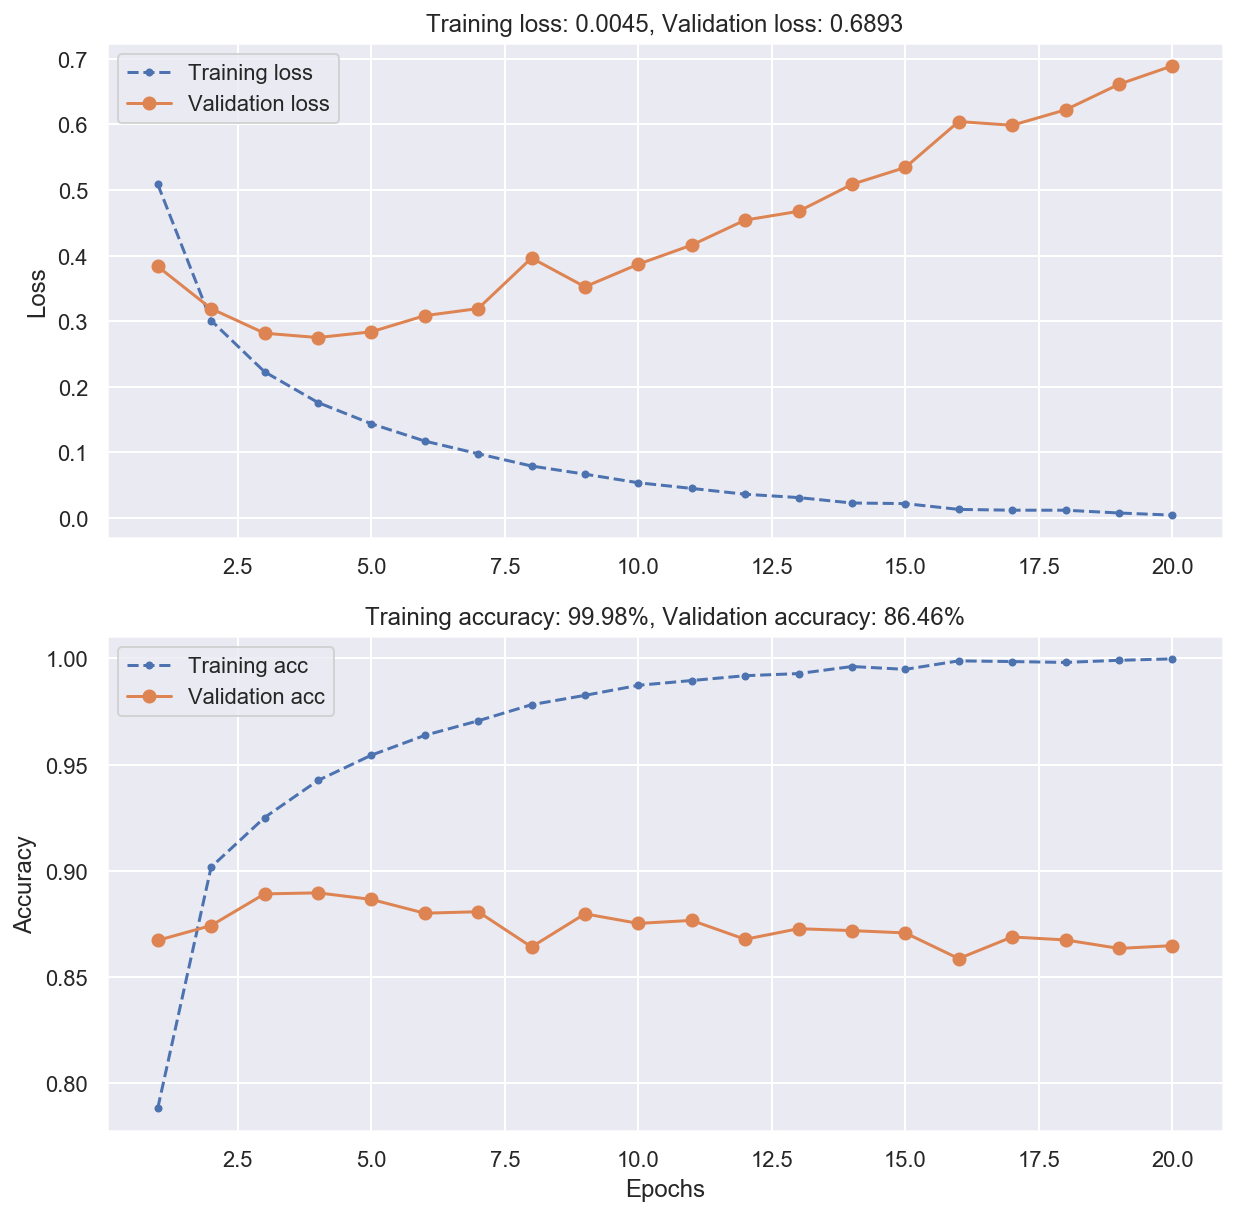

In [37]:
# Build a (10000, 16, 16, 1) NN to demonstrate overfitting
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Show model info
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# We also record validation history during training
history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

In [38]:
# Evaluate model performance on test data
_, test_acc = model.evaluate(x_test, y_test)

print(f'Test accuracy: {test_acc * 100:.2f}%')

25000/25000 [==============================] - 4s 161us/sample - loss: 0.7673 - accuracy: 0.8475
Test accuracy: 84.75%


### Reducing network size

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 154us/sample - loss: 0.5789 - accuracy: 0.7223 - val_loss: 0.4889 - val_accuracy: 0.8270
Epoch 2/20
15000/15000 [==============================] - 1s 94us/sample - loss: 0.4103 - accuracy: 0.8853 - val_loss: 0.3889 - val_accuracy: 0.8811
Epoch 3/20
15000/15000 [======

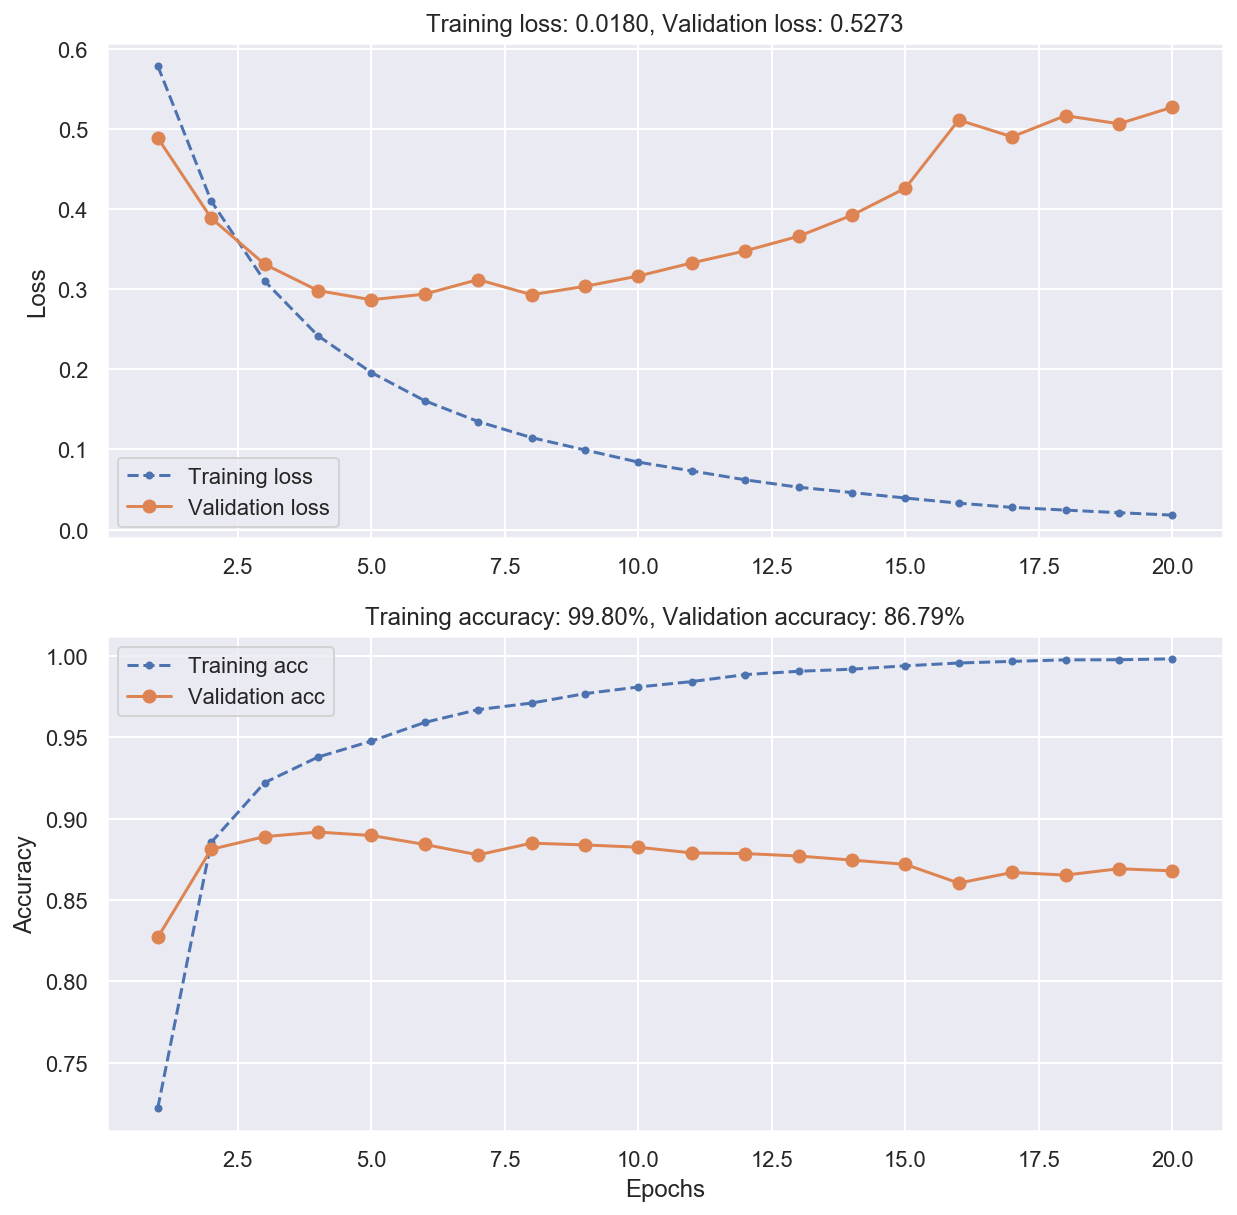

In [39]:
# Build and train a smaller network
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(10000,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Show model info to check the new number of parameters
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

### Regularization

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 159us/sample - loss: 0.5508 - accuracy: 0.7756 - val_loss: 0.4381 - val_accuracy: 0.8647
Epoch 2/20
15000/15000 [==============================] - 2s 111us/sample - loss: 0.3673 - accuracy: 0.8943 - val_loss: 0.3565 - val_accuracy: 0.8823
Epoch 3/20
15000/15000 [=====

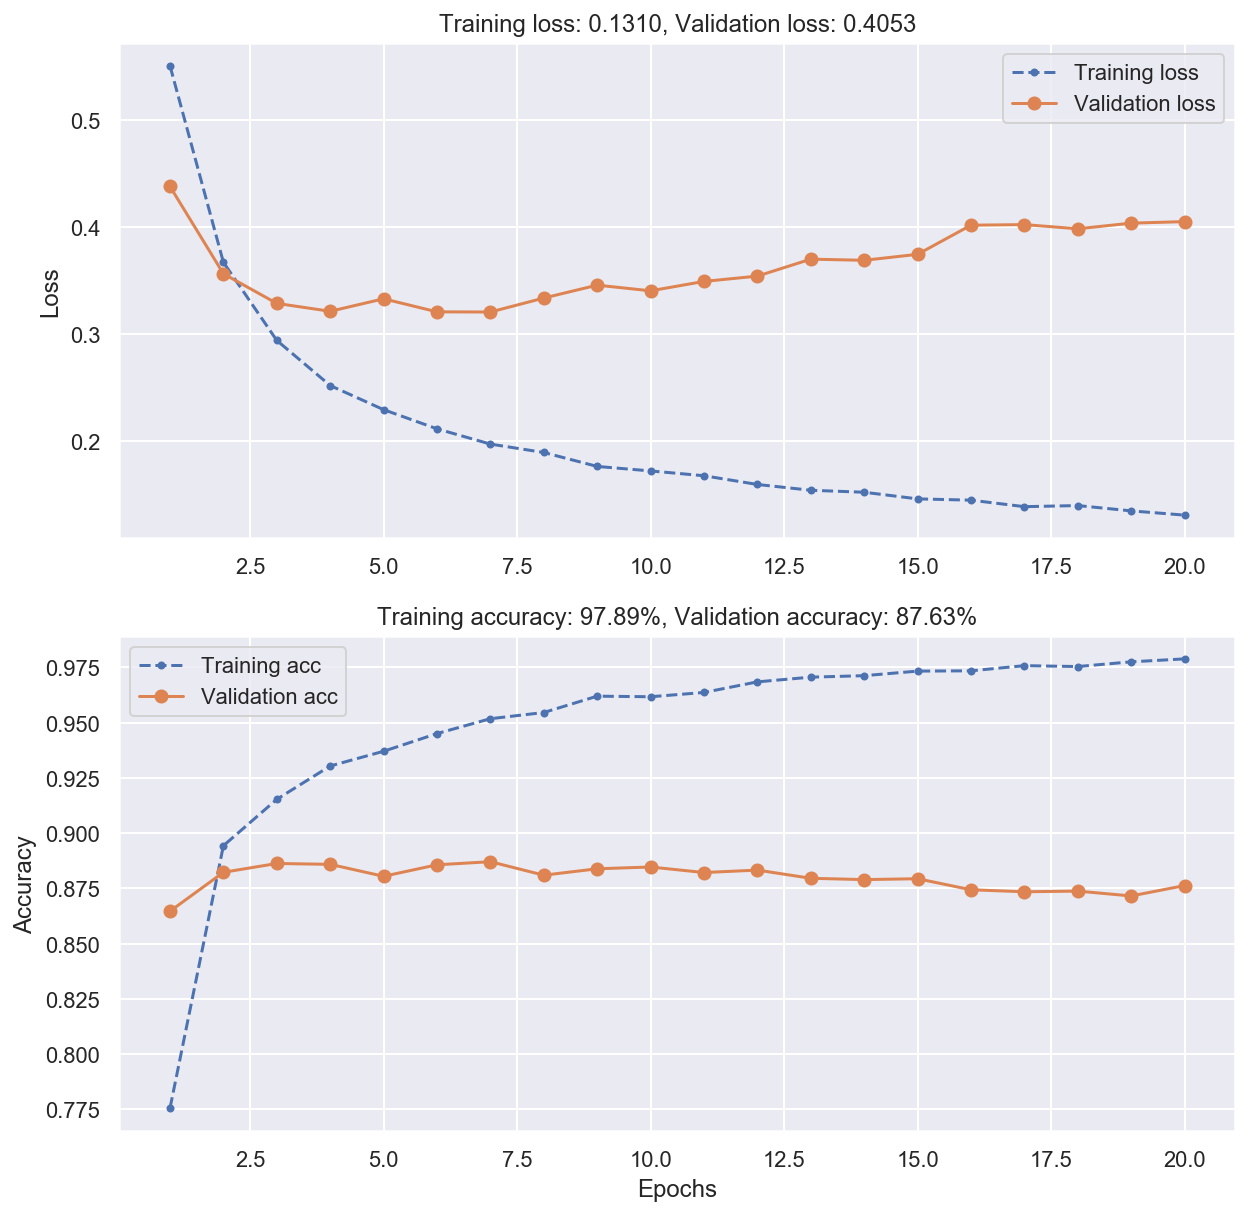

In [40]:
# Create the same model as before but now using L2 regularization
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(10000,),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

# Show model info
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

### Dropout

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 8)                 80008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 9         
Total params: 80,089
Trainable params: 80,089
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 151u

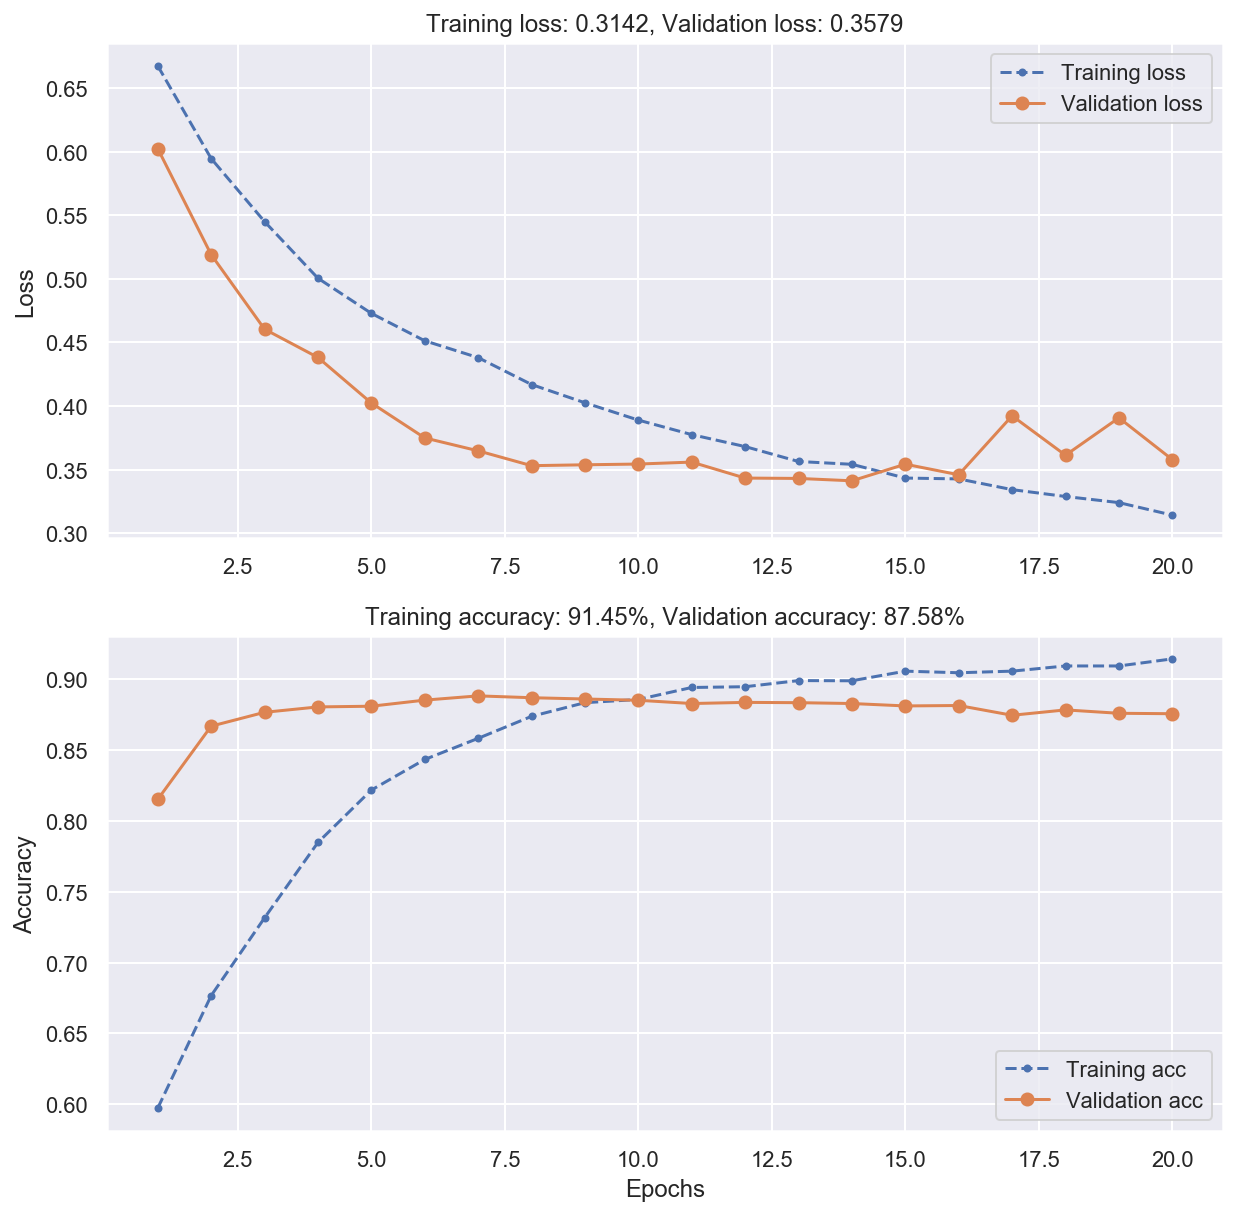

In [41]:
# Add 50% dropout to the two hidden layers
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(10000,),
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Show model info
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_val, y_val))
plot_loss_acc(history)

In [43]:
# Evaluate tuned model performance on test data
_, test_acc = model.evaluate(x_test, y_test)

print(f'Test accuracy: {test_acc * 100:.2f}%')

25000/25000 [==============================] - 2s 75us/sample - loss: 0.3690 - accuracy: 0.8716s - loss: 0.3737  - ETA: 0s - loss: 0.3685 - accuracy: 
Test accuracy: 87.16%
